In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# Load the CSV file - replace with your actual file path
csv_path = '/content/rs74908652_scores.csv'
  # Update this path
df = pd.read_csv(csv_path)

print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Analyze Assay titles
print(f"\n🧪 ASSAY ANALYSIS:")
print(f"Total unique assays: {df['Assay title'].nunique()}")
assay_counts = df['Assay title'].value_counts()
print(f"\nAssay distribution:")
for assay, count in assay_counts.items():
    print(f"  {assay}: {count:,} entries")

# Analyze biosample types
print(f"\n🔬 BIOSAMPLE TYPE ANALYSIS:")
print(f"Total unique biosample types: {df['biosample_type'].nunique()}")
biosample_counts = df['biosample_type'].value_counts()
print(f"\nBiosample type distribution:")
for biosample_type, count in biosample_counts.items():
    print(f"  {biosample_type}: {count:,} entries")

# Focus on target biosample types
target_types = ['cell_line', 'primary_cell', 'tissue']
target_data = df[df['biosample_type'].isin(target_types)]
print(f"\n🎯 TARGET BIOSAMPLE TYPES DATA:")
print(f"Filtered data shape: {target_data.shape} (from {df.shape[0]} total)")
target_biosample_counts = target_data['biosample_type'].value_counts()
print(f"Target biosample distribution:")
for biosample_type, count in target_biosample_counts.items():
    print(f"  {biosample_type}: {count:,} entries")

df.head()

Data shape: (60127, 25)
Columns: ['variant_id', 'scored_interval', 'gene_id', 'gene_name', 'gene_type', 'gene_strand', 'junction_Start', 'junction_End', 'output_type', 'variant_scorer', 'track_name', 'track_strand', 'Assay title', 'ontology_curie', 'biosample_name', 'biosample_type', 'biosample_life_stage', 'data_source', 'endedness', 'genetically_modified', 'transcription_factor', 'histone_mark', 'gtex_tissue', 'raw_score', 'quantile_score']

🧪 ASSAY ANALYSIS:
Total unique assays: 12

Assay distribution:
  total RNA-seq: 26,481 entries
  polyA plus RNA-seq: 26,090 entries
  TF ChIP-seq: 3,234 entries
  Histone ChIP-seq: 2,232 entries
  hCAGE: 1,032 entries
  DNase-seq: 610 entries
  ATAC-seq: 334 entries
  LQhCAGE: 60 entries
  in situ Hi-C: 24 entries
  PRO-cap: 24 entries
  Micro-C: 3 entries
  Dilution Hi-C: 1 entries

🔬 BIOSAMPLE TYPE ANALYSIS:
Total unique biosample types: 5

Biosample type distribution:
  tissue: 26,610 entries
  primary_cell: 15,299 entries
  cell_line: 14,016 

variant_id            scored_interval gene_id gene_name gene_type  \
0  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN       NaN   
1  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN       NaN   
2  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN       NaN   
3  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN       NaN   
4  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN       NaN   

  gene_strand  junction_Start  junction_End output_type  \
0         NaN             NaN           NaN        ATAC   
1         NaN             NaN           NaN        ATAC   
2         NaN             NaN           NaN        ATAC   
3         NaN             NaN           NaN        ATAC   
4         NaN             NaN           NaN        ATAC   

                                      variant_scorer  ...  \
0  CenterMaskScorer(requested_output=ATAC, width=...  ...   
1  CenterMaskScorer(requested_output=ATAC, width=...  ...   
2  CenterMaskScorer(requested_output=ATAC, width=...  ...   
3  CenterMaskScorer(requested_output=ATAC, width=...  ...   
4  CenterMaskScorer(requested_output=ATAC, width=...  ...   

                  biosample_type biosample_life_stage data_source endedness  \
0                   primary_cell                adult      encode    paired   
1  in_vitro_differentiated_cells                adult      encode    paired   
2                   primary_cell                adult      encode    paired   
3                   primary_cell                adult      encode    paired   
4                   primary_cell                adult      encode    paired   

  genetically_modified transcription_factor histone_mark gtex_tissue  \
0                False                  NaN          NaN         NaN   
1                False                  NaN          NaN         NaN   
2                False                  NaN          NaN         NaN   
3                False                  NaN          NaN         NaN   
4                False                  NaN          NaN         NaN   

  raw_score quantile_score  
0 -0.004216      -0.226711  
1 -0.010991      -0.312224  
2 -0.002648      -0.171333  
3 -0.003349      -0.215740  
4 -0.005479      -0.291254  

[5 rows x 25 columns]

In [13]:
# Filter for extreme values only (< -0.99 or > 0.99) and target biosample types
target_types = ['cell_line', 'primary_cell', 'tissue']

# Filter for target biosample types
target_data = df[df['biosample_type'].isin(target_types)].copy()

# Filter for extreme quantile scores only
extreme_mask = (target_data['quantile_score'] < -0.99) | (target_data['quantile_score'] > 0.99)
extreme_data = target_data[extreme_mask].copy()

print(f"🔥 EXTREME VALUES ANALYSIS:")
print(f"Original data: {len(df):,} entries")
print(f"Target biosample types: {len(target_data):,} entries")
print(f"Extreme values only: {len(extreme_data):,} entries")
print(f"Extreme percentage of target data: {len(extreme_data)/len(target_data)*100:.2f}%")

if len(extreme_data) == 0:
    print("❌ No extreme values found! Adjusting thresholds...")
    # Use more lenient thresholds if no extreme values
    extreme_mask = (target_data['quantile_score'] < -0.95) | (target_data['quantile_score'] > 0.95)
    extreme_data = target_data[extreme_mask].copy()
    print(f"Using threshold ±0.95: {len(extreme_data):,} entries")

if len(extreme_data) > 0:
    print(f"\n📊 EXTREME VALUES BY BIOSAMPLE TYPE:")
    extreme_by_type = extreme_data['biosample_type'].value_counts()
    for biosample_type, count in extreme_by_type.items():
        percentage = count / len(extreme_data) * 100
        print(f"  {biosample_type}: {count:,} ({percentage:.1f}%)")
    
    print(f"\n🧪 EXTREME VALUES BY ASSAY:")
    extreme_by_assay = extreme_data['Assay title'].value_counts()
    for assay, count in extreme_by_assay.items():
        percentage = count / len(extreme_data) * 100
        print(f"  {assay}: {count:,} ({percentage:.1f}%)")
    
    print(f"\n📈 QUANTILE SCORE DISTRIBUTION:")
    print(f"Min score: {extreme_data['quantile_score'].min():.4f}")
    print(f"Max score: {extreme_data['quantile_score'].max():.4f}")
    print(f"Mean score: {extreme_data['quantile_score'].mean():.4f}")
    
    # Check for specific extreme ranges
    very_low = (extreme_data['quantile_score'] <= -0.99).sum()
    very_high = (extreme_data['quantile_score'] >= 0.99).sum()
    print(f"Very low (≤-0.99): {very_low:,}")
    print(f"Very high (≥0.99): {very_high:,}")
    
    display(extreme_data.head(10))
else:
    print("❌ No extreme values found even with relaxed thresholds.")
    print("Showing quantile score distribution:")
    print(target_data['quantile_score'].describe())

🔥 EXTREME VALUES ANALYSIS:
Original data: 60,127 entries
Target biosample types: 55,925 entries
Extreme values only: 3,423 entries
Extreme percentage of target data: 6.12%

📊 EXTREME VALUES BY BIOSAMPLE TYPE:
  cell_line: 1,530 (44.7%)
  tissue: 986 (28.8%)
  primary_cell: 907 (26.5%)

🧪 EXTREME VALUES BY ASSAY:
  TF ChIP-seq: 842 (24.6%)
  total RNA-seq: 822 (24.0%)
  polyA plus RNA-seq: 623 (18.2%)
  Histone ChIP-seq: 372 (10.9%)
  DNase-seq: 284 (8.3%)
  hCAGE: 277 (8.1%)
  ATAC-seq: 166 (4.8%)
  LQhCAGE: 25 (0.7%)
  PRO-cap: 12 (0.4%)

📈 QUANTILE SCORE DISTRIBUTION:
Min score: -0.9997
Max score: 1.0000
Mean score: 0.8257
Very low (≤-0.99): 293
Very high (≥0.99): 3,130


variant_id            scored_interval gene_id gene_name  \
606  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN   
613  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN   
614  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN   
646  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN   
660  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN   
670  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN   
682  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN   
685  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN   
701  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN   
712  chr19:10718233:T>C  chr19:10193945-11242521:.     NaN       NaN   

    gene_type gene_strand  junction_Start  junction_End output_type  \
606       NaN         NaN             NaN           NaN     CHIP_TF   
613       NaN         NaN             NaN           NaN     CHIP_TF   
614       NaN         NaN             NaN           NaN     CHIP_TF   
646       NaN         NaN             NaN           NaN     CHIP_TF   
660       NaN         NaN             NaN           NaN     CHIP_TF   
670       NaN         NaN             NaN           NaN     CHIP_TF   
682       NaN         NaN             NaN           NaN     CHIP_TF   
685       NaN         NaN             NaN           NaN     CHIP_TF   
701       NaN         NaN             NaN           NaN     CHIP_TF   
712       NaN         NaN             NaN           NaN     CHIP_TF   

                                        variant_scorer  ... biosample_type  \
606  CenterMaskScorer(requested_output=CHIP_TF, wid...  ...      cell_line   
613  CenterMaskScorer(requested_output=CHIP_TF, wid...  ...      cell_line   
614  CenterMaskScorer(requested_output=CHIP_TF, wid...  ...      cell_line   
646  CenterMaskScorer(requested_output=CHIP_TF, wid...  ...      cell_line   
660  CenterMaskScorer(requested_output=CHIP_TF, wid...  ...      cell_line   
670  CenterMaskScorer(requested_output=CHIP_TF, wid...  ...      cell_line   
682  CenterMaskScorer(requested_output=CHIP_TF, wid...  ...      cell_line   
685  CenterMaskScorer(requested_output=CHIP_TF, wid...  ...      cell_line   
701  CenterMaskScorer(requested_output=CHIP_TF, wid...  ...      cell_line   
712  CenterMaskScorer(requested_output=CHIP_TF, wid...  ...      cell_line   

    biosample_life_stage data_source endedness genetically_modified  \
606            embryonic      encode    paired                 True   
613            embryonic      encode    paired                 True   
614            embryonic      encode    paired                 True   
646            embryonic      encode    paired                 True   
660            embryonic      encode    paired                 True   
670            embryonic      encode    paired                 True   
682            embryonic      encode    paired                 True   
685            embryonic      encode    paired                 True   
701            embryonic      encode    paired                 True   
712            embryonic      encode    paired                False   

    transcription_factor histone_mark gtex_tissue raw_score quantile_score  
606               BCL11A          NaN         NaN -0.119932      -0.991201  
613                GLIS2          NaN         NaN -0.130535      -0.990355  
614                 HIC1          NaN         NaN -0.129635      -0.991401  
646               ZBTB10          NaN         NaN -0.165973      -0.995379  
660                ZFP37          NaN         NaN -0.145572      -0.993622  
670                 ZNF2          NaN         NaN -0.133583      -0.991201  
682               ZNF423          NaN         NaN -0.119471      -0.990997  
685               ZNF501          NaN         NaN -0.160514      -0.995161  
701               ZNF680          NaN         NaN -0.125641      -0.993622  
712              L3MBTL2   

📊 ASSAY DISTRIBUTION SUMMARY:
Total number of unique assays: 12
Total entries (after removing NaN): 60,125
Removed NaN entries: 2

🔍 Detailed breakdown:
 1. total RNA-seq: 26,481 entries (44.0%)
 2. polyA plus RNA-seq: 26,090 entries (43.4%)
 3. TF ChIP-seq: 3,234 entries (5.4%)
 4. Histone ChIP-seq: 2,232 entries (3.7%)
 5. hCAGE: 1,032 entries (1.7%)
 6. DNase-seq: 610 entries (1.0%)
 7. ATAC-seq: 334 entries (0.6%)
 8. LQhCAGE: 60 entries (0.1%)
 9. in situ Hi-C: 24 entries (0.0%)
10. PRO-cap: 24 entries (0.0%)
11. Micro-C: 3 entries (0.0%)
12. Dilution Hi-C: 1 entries (0.0%)


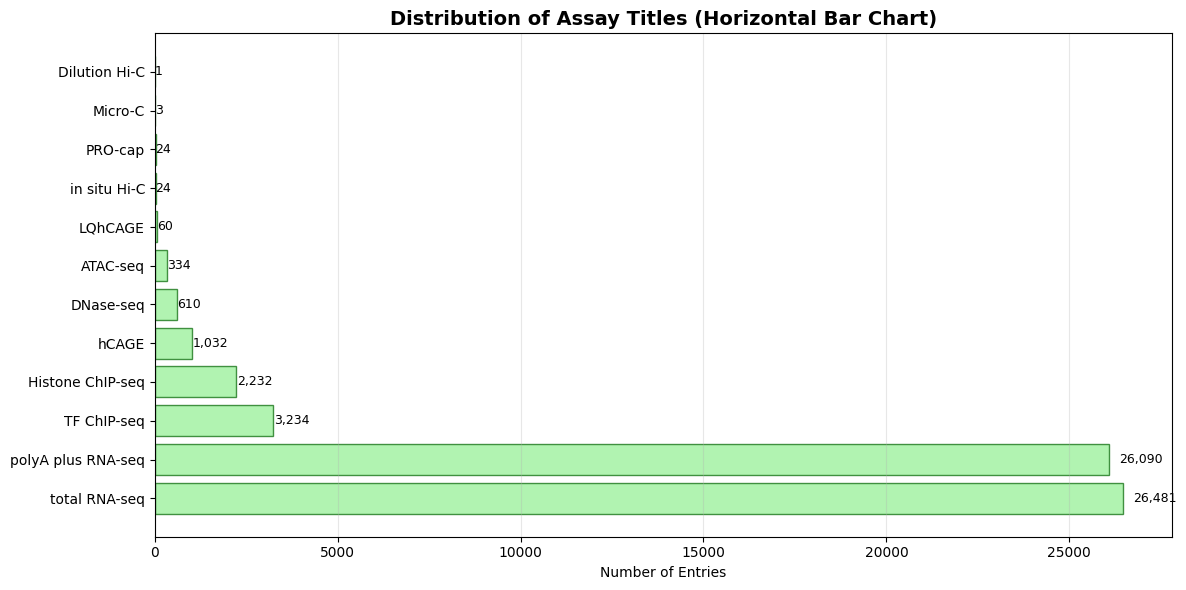


📈 QUANTILE SCORE DISTRIBUTION BY ASSAY:
 1. ATAC-seq:
    Count: 334
    Mean: 0.4315
    Std: 0.6114
    Min: -0.8535
    Max: 0.9986
 2. Micro-C:
    Count: 3
    Mean: 0.7770
    Std: 0.0713
    Min: 0.7156
    Max: 0.8553
 3. in situ Hi-C:
    Count: 24
    Mean: 0.7024
    Std: 0.0973
    Min: 0.5231
    Max: 0.8435
 4. Dilution Hi-C:
    Count: 1
    Mean: 0.8716
    Std: nan
    Min: 0.8716
    Max: 0.8716
 5. DNase-seq:
    Count: 610
    Mean: 0.3458
    Std: 0.6642
    Min: -0.7679
    Max: 0.9987
 6. TF ChIP-seq:
    Count: 3,234
    Mean: 0.1928
    Std: 0.8187
    Min: -0.9984
    Max: 0.9999
 7. Histone ChIP-seq:
    Count: 2,232
    Mean: 0.1353
    Std: 0.7543
    Min: -0.9881
    Max: 0.9998
 8. LQhCAGE:
    Count: 60
    Mean: 0.9255
    Std: 0.0866
    Min: 0.6351
    Max: 0.9999
 9. hCAGE:
    Count: 1,032
    Mean: 0.8228
    Std: 0.2879
    Min: -0.7772
    Max: 0.9999
10. PRO-cap:
    Count: 24
    Mean: 0.9170
    Std: 0.1136
    Min: 0.5119
    Max: 0.9997
11.

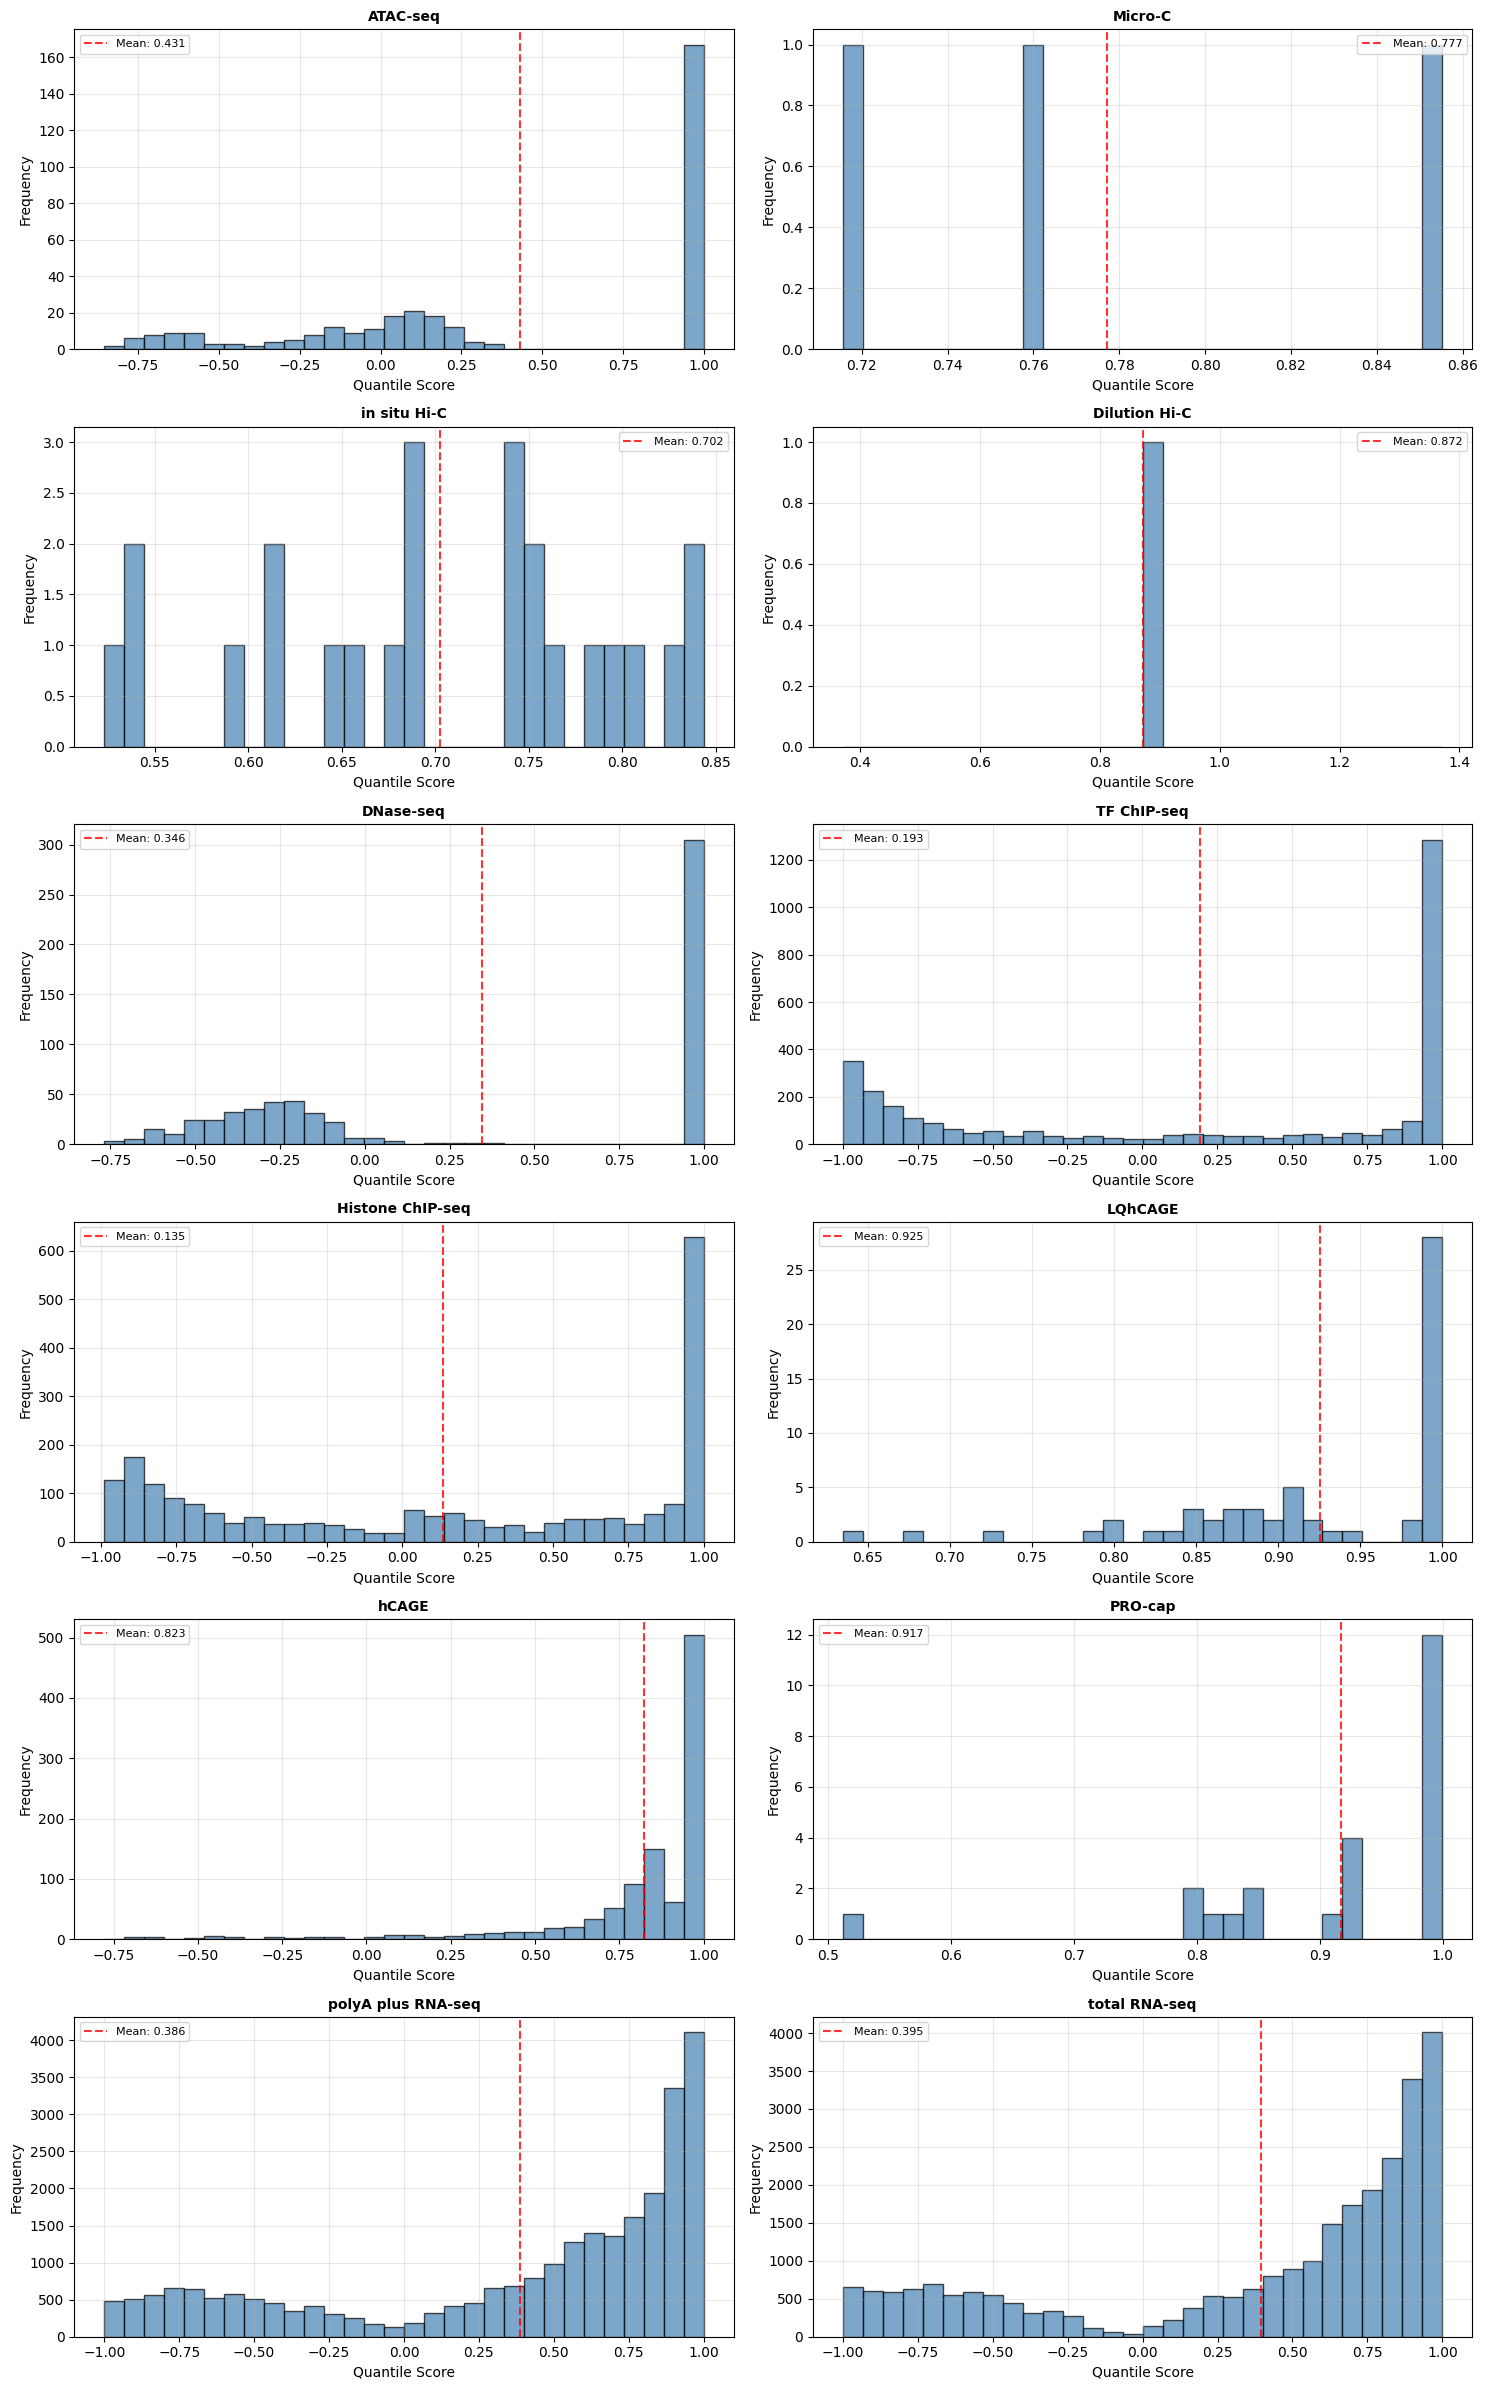

In [14]:
# Create histogram for Assay title distribution
# Filter out rows with NaN assay titles
df_clean = df.dropna(subset=['Assay title']).copy()
assay_counts = df_clean['Assay title'].value_counts()

# Print detailed assay information
print("📊 ASSAY DISTRIBUTION SUMMARY:")
print(f"Total number of unique assays: {len(assay_counts)}")
print(f"Total entries (after removing NaN): {len(df_clean):,}")
print(f"Removed NaN entries: {len(df) - len(df_clean):,}")
print("\n🔍 Detailed breakdown:")
for i, (assay, count) in enumerate(assay_counts.items(), 1):
    percentage = (count / len(df_clean)) * 100
    print(f"{i:2d}. {assay}: {count:,} entries ({percentage:.1f}%)")

# Create a horizontal bar chart for better readability of assay names
plt.figure(figsize=(12, max(6, len(assay_counts) * 0.4)))
y_pos = np.arange(len(assay_counts))
bars = plt.barh(y_pos, assay_counts.values, color='lightgreen', alpha=0.7, edgecolor='darkgreen')

plt.yticks(y_pos, [name[:50] + '...' if len(name) > 50 else name for name in assay_counts.index], fontsize=10)
plt.xlabel('Number of Entries')
plt.title('Distribution of Assay Titles (Horizontal Bar Chart)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2.,
             f'{int(width):,}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Create histograms of quantile scores for each assay
print("\n📈 QUANTILE SCORE DISTRIBUTION BY ASSAY:")
unique_assays = df_clean['Assay title'].unique()

# Calculate number of rows and columns for subplots
n_assays = len(unique_assays)
ncols = 2
nrows = (n_assays + ncols - 1) // ncols

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4*nrows))
if nrows == 1:
    axes = axes.reshape(1, -1) if ncols > 1 else [axes]
elif n_assays == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for i, assay in enumerate(unique_assays):
    assay_data = df_clean[df_clean['Assay title'] == assay]['quantile_score']
    
    # Create histogram
    axes[i].hist(assay_data, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    
    # Handle long assay names safely
    title = str(assay)  # Ensure it's a string
    if len(title) > 40:
        title = title[:40] + '...'
    
    axes[i].set_title(title, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Quantile Score')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.3)
    
    # Add statistics text
    mean_score = assay_data.mean()
    std_score = assay_data.std()
    axes[i].axvline(mean_score, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_score:.3f}')
    axes[i].legend(fontsize=8)
    
    # Print statistics
    print(f"{i+1:2d}. {assay}:")
    print(f"    Count: {len(assay_data):,}")
    print(f"    Mean: {mean_score:.4f}")
    print(f"    Std: {std_score:.4f}")
    print(f"    Min: {assay_data.min():.4f}")
    print(f"    Max: {assay_data.max():.4f}")

# Hide empty subplots
for i in range(n_assays, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

🔬 EXTREME VALUES: BIOSAMPLE NAME vs RAW VALUES BY CELL TYPE AND ASSAY
Original data: 60,127 entries
Filtered for target cell types: 55,925 entries
Extreme values (≤-0.99 or ≥0.99): 3,423 entries
After removing NaN values: 3,423 entries

📊 Found 24 combinations of cell type + assay:
  cell_line / ATAC-seq: 105 entries
  cell_line / DNase-seq: 107 entries
  cell_line / Histone ChIP-seq: 135 entries
  cell_line / PRO-cap: 10 entries
  cell_line / TF ChIP-seq: 801 entries
  cell_line / hCAGE: 20 entries
  cell_line / polyA plus RNA-seq: 150 entries
  cell_line / total RNA-seq: 202 entries
  primary_cell / ATAC-seq: 14 entries
  primary_cell / DNase-seq: 82 entries
  primary_cell / Histone ChIP-seq: 82 entries
  primary_cell / LQhCAGE: 25 entries
  primary_cell / PRO-cap: 2 entries
  primary_cell / TF ChIP-seq: 6 entries
  primary_cell / hCAGE: 152 entries
  primary_cell / polyA plus RNA-seq: 160 entries
  primary_cell / total RNA-seq: 384 entries
  tissue / ATAC-seq: 47 entries
  tissue / 

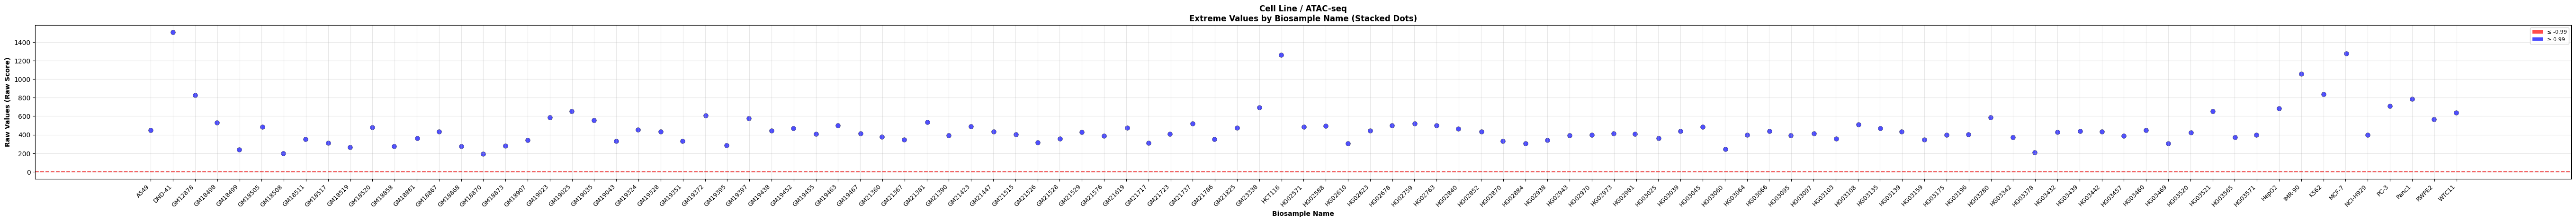

   Statistics:
     Mean: 467.4639
     Min: 193.9606
     Max: 1508.6332
     Very low (≤-0.99): 0
     Very high (≥0.99): 105
   Biosample frequency:
     A549: 1 entries
     DND-41: 1 entries
     GM12878: 1 entries
     GM18498: 1 entries
     GM18499: 1 entries
     GM18505: 1 entries
     GM18508: 1 entries
     GM18511: 1 entries
     GM18517: 1 entries
     GM18519: 1 entries
     GM18520: 1 entries
     GM18858: 1 entries
     GM18861: 1 entries
     GM18867: 1 entries
     GM18868: 1 entries
     GM18870: 1 entries
     GM18873: 1 entries
     GM18907: 1 entries
     GM19023: 1 entries
     GM19025: 1 entries
     GM19035: 1 entries
     GM19043: 1 entries
     GM19324: 1 entries
     GM19328: 1 entries
     GM19351: 1 entries
     GM19372: 1 entries
     GM19395: 1 entries
     GM19397: 1 entries
     GM19438: 1 entries
     GM19452: 1 entries
     GM19455: 1 entries
     GM19463: 1 entries
     GM19467: 1 entries
     GM21360: 1 entries
     GM21367: 1 entries
     GM21381

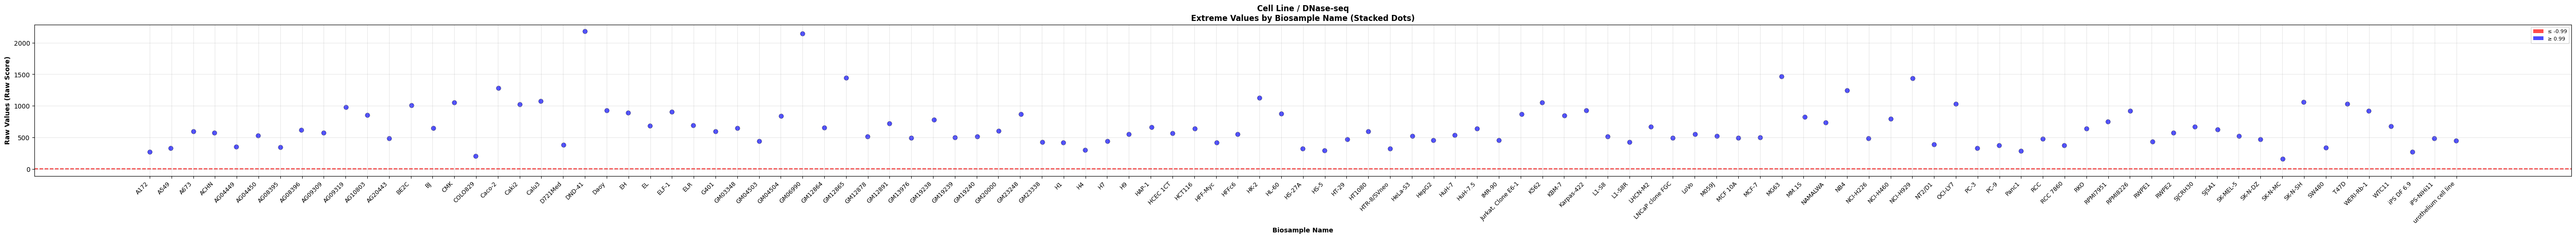

   Statistics:
     Mean: 671.6659
     Min: 158.0569
     Max: 2180.4675
     Very low (≤-0.99): 0
     Very high (≥0.99): 107
   Biosample frequency:
     A172: 1 entries
     A549: 1 entries
     A673: 1 entries
     ACHN: 1 entries
     AG04449: 1 entries
     AG04450: 1 entries
     AG08395: 1 entries
     AG08396: 1 entries
     AG09309: 1 entries
     AG09319: 1 entries
     AG10803: 1 entries
     AG20443: 1 entries
     BE2C: 1 entries
     BJ: 1 entries
     CMK: 1 entries
     COLO829: 1 entries
     Caco-2: 1 entries
     Caki2: 1 entries
     Calu3: 1 entries
     D721Med: 1 entries
     DND-41: 1 entries
     Daoy: 1 entries
     EH: 1 entries
     EL: 1 entries
     ELF-1: 1 entries
     ELR: 1 entries
     G401: 1 entries
     GM03348: 1 entries
     GM04503: 1 entries
     GM04504: 1 entries
     GM06990: 1 entries
     GM12864: 1 entries
     GM12865: 1 entries
     GM12878: 1 entries
     GM12891: 1 entries
     GM13976: 1 entries
     GM19238: 1 entries
     GM19239

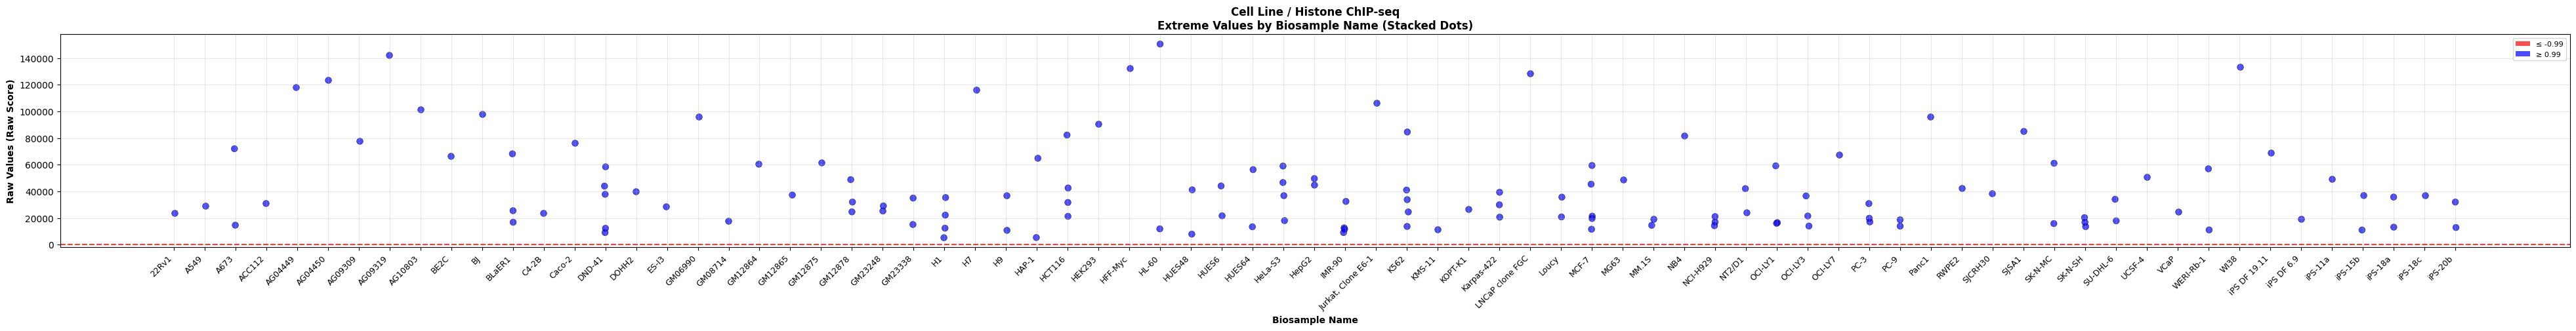

   Statistics:
     Mean: 41611.4690
     Min: 5188.5000
     Max: 150492.5000
     Very low (≤-0.99): 0
     Very high (≥0.99): 135
   Biosample frequency:
     MCF-7: 5 entries
     K562: 5 entries
     DND-41: 5 entries
     HCT116: 4 entries
     H1: 4 entries
     HeLa-S3: 4 entries
     IMR-90: 4 entries
     GM12878: 3 entries
     PC-3: 3 entries
     SK-N-SH: 3 entries
     OCI-LY1: 3 entries
     Karpas-422: 3 entries
     NCI-H929: 3 entries
     BLaER1: 3 entries
     OCI-LY3: 3 entries
     iPS-18a: 2 entries
     Loucy: 2 entries
     WERI-Rb-1: 2 entries
     PC-9: 2 entries
     MM.1S: 2 entries
     HAP-1: 2 entries
     A673: 2 entries
     SU-DHL-6: 2 entries
     iPS-20b: 2 entries
     iPS-15b: 2 entries
     NT2/D1: 2 entries
     HL-60: 2 entries
     HUES48: 2 entries
     SK-N-MC: 2 entries
     H9: 2 entries
     HUES6: 2 entries
     GM23338: 2 entries
     GM23248: 2 entries
     HUES64: 2 entries
     HepG2: 2 entries
     A549: 1 entries
     22Rv1: 1 entr

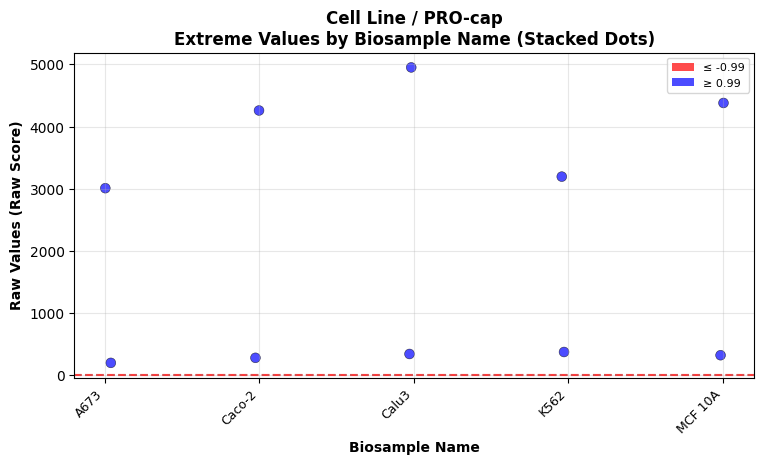

   Statistics:
     Mean: 2132.0704
     Min: 201.1902
     Max: 4950.8887
     Very low (≤-0.99): 0
     Very high (≥0.99): 10
   Biosample frequency:
     A673: 2 entries
     Caco-2: 2 entries
     Calu3: 2 entries
     K562: 2 entries
     MCF 10A: 2 entries

📈 Plotting: cell_line / TF ChIP-seq
   Entries: 801
   Unique biosample names: 32


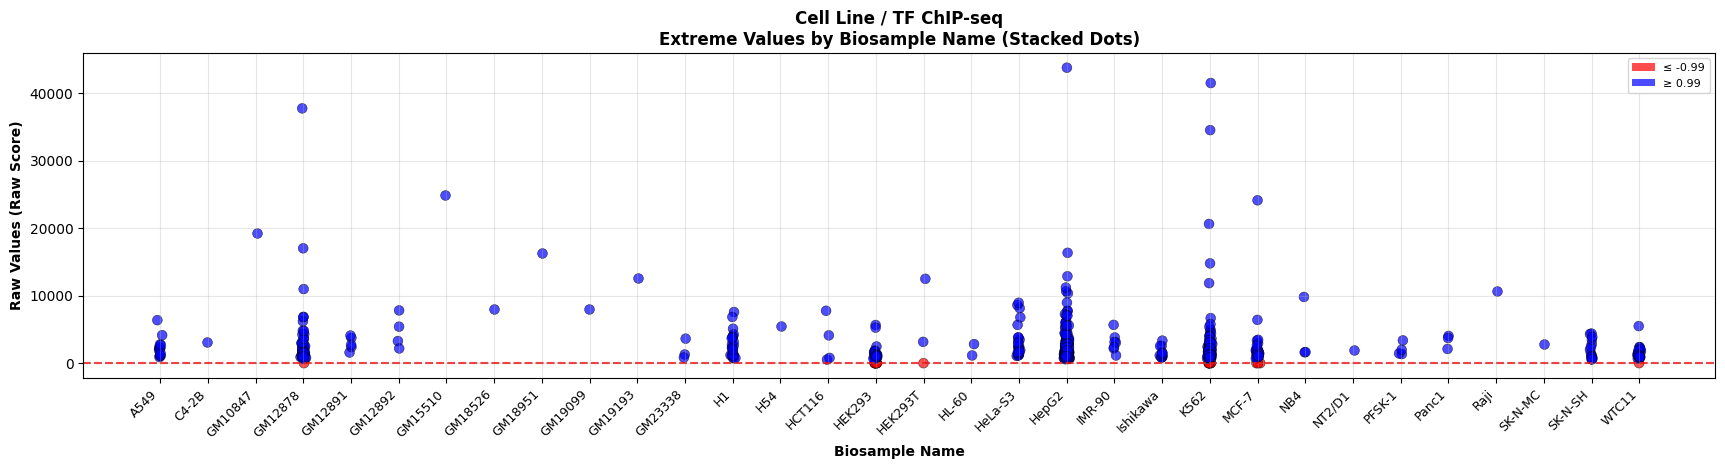

   Statistics:
     Mean: 2429.0650
     Min: -0.2570
     Max: 43776.0000
     Very low (≤-0.99): 0
     Very high (≥0.99): 779
   Biosample frequency:
     HepG2: 382 entries
     K562: 124 entries
     GM12878: 62 entries
     HEK293: 37 entries
     MCF-7: 32 entries
     WTC11: 27 entries
     H1: 25 entries
     HeLa-S3: 24 entries
     SK-N-SH: 14 entries
     A549: 13 entries
     Ishikawa: 12 entries
     IMR-90: 7 entries
     GM12891: 5 entries
     HCT116: 4 entries
     GM12892: 4 entries
     PFSK-1: 4 entries
     GM23338: 3 entries
     HEK293T: 3 entries
     Panc1: 3 entries
     NB4: 3 entries
     HL-60: 2 entries
     C4-2B: 1 entries
     GM15510: 1 entries
     GM18526: 1 entries
     H54: 1 entries
     GM18951: 1 entries
     GM19099: 1 entries
     GM19193: 1 entries
     GM10847: 1 entries
     NT2/D1: 1 entries
     SK-N-MC: 1 entries
     Raji: 1 entries

📈 Plotting: cell_line / hCAGE
   Entries: 20
   Unique biosample names: 19


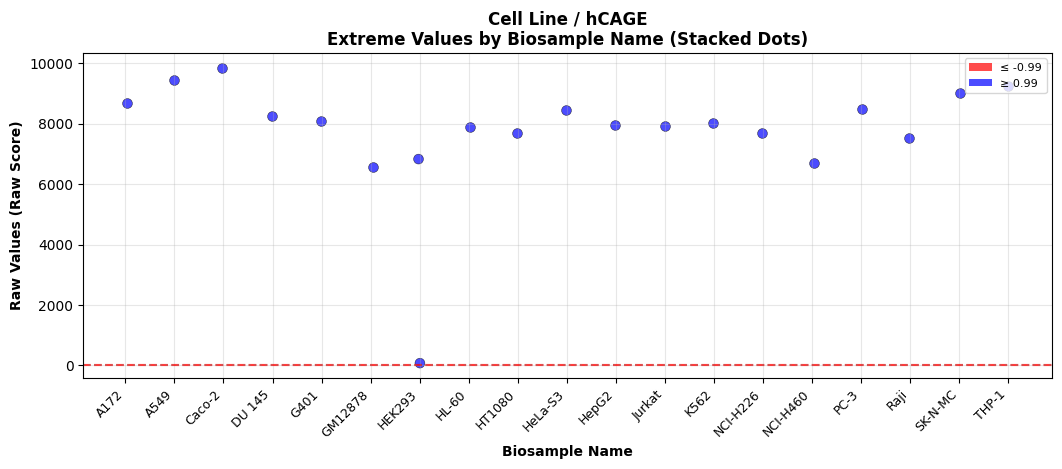

   Statistics:
     Mean: 7722.9178
     Min: 76.4340
     Max: 9856.5310
     Very low (≤-0.99): 0
     Very high (≥0.99): 20
   Biosample frequency:
     HEK293: 2 entries
     A549: 1 entries
     A172: 1 entries
     Caco-2: 1 entries
     DU 145: 1 entries
     G401: 1 entries
     GM12878: 1 entries
     HL-60: 1 entries
     HT1080: 1 entries
     HeLa-S3: 1 entries
     HepG2: 1 entries
     Jurkat: 1 entries
     K562: 1 entries
     NCI-H226: 1 entries
     NCI-H460: 1 entries
     PC-3: 1 entries
     Raji: 1 entries
     SK-N-MC: 1 entries
     THP-1: 1 entries

📈 Plotting: cell_line / polyA plus RNA-seq
   Entries: 150
   Unique biosample names: 28


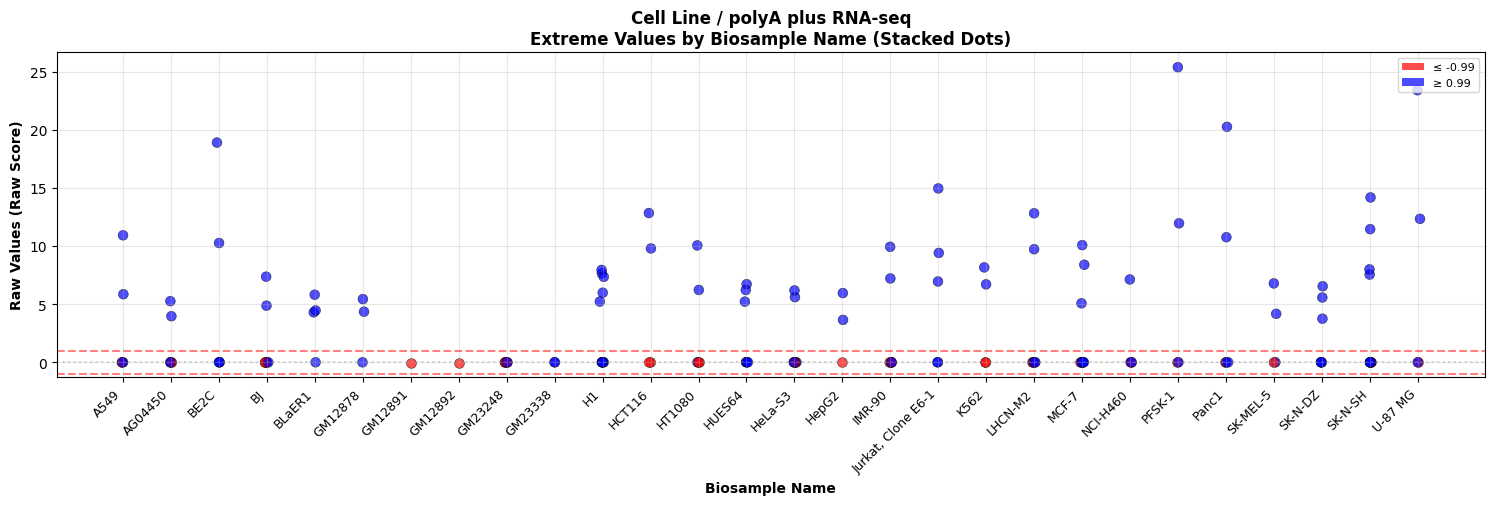

   Statistics:
     Mean: 3.2941
     Min: -0.0214
     Max: 25.4109
     Very low (≤-0.99): 0
     Very high (≥0.99): 57
   Biosample frequency:
     H1: 11 entries
     SK-N-SH: 11 entries
     MCF-7: 11 entries
     HeLa-S3: 8 entries
     HUES64: 7 entries
     IMR-90: 7 entries
     SK-N-DZ: 7 entries
     LHCN-M2: 7 entries
     BJ: 7 entries
     AG04450: 6 entries
     BE2C: 5 entries
     A549: 5 entries
     HT1080: 5 entries
     Panc1: 5 entries
     GM23248: 5 entries
     Jurkat, Clone E6-1: 5 entries
     HCT116: 4 entries
     BLaER1: 4 entries
     PFSK-1: 4 entries
     K562: 4 entries
     SK-MEL-5: 4 entries
     NCI-H460: 4 entries
     U-87 MG: 4 entries
     GM12878: 3 entries
     HepG2: 3 entries
     GM23338: 2 entries
     GM12891: 1 entries
     GM12892: 1 entries

📈 Plotting: cell_line / total RNA-seq
   Entries: 202
   Unique biosample names: 38


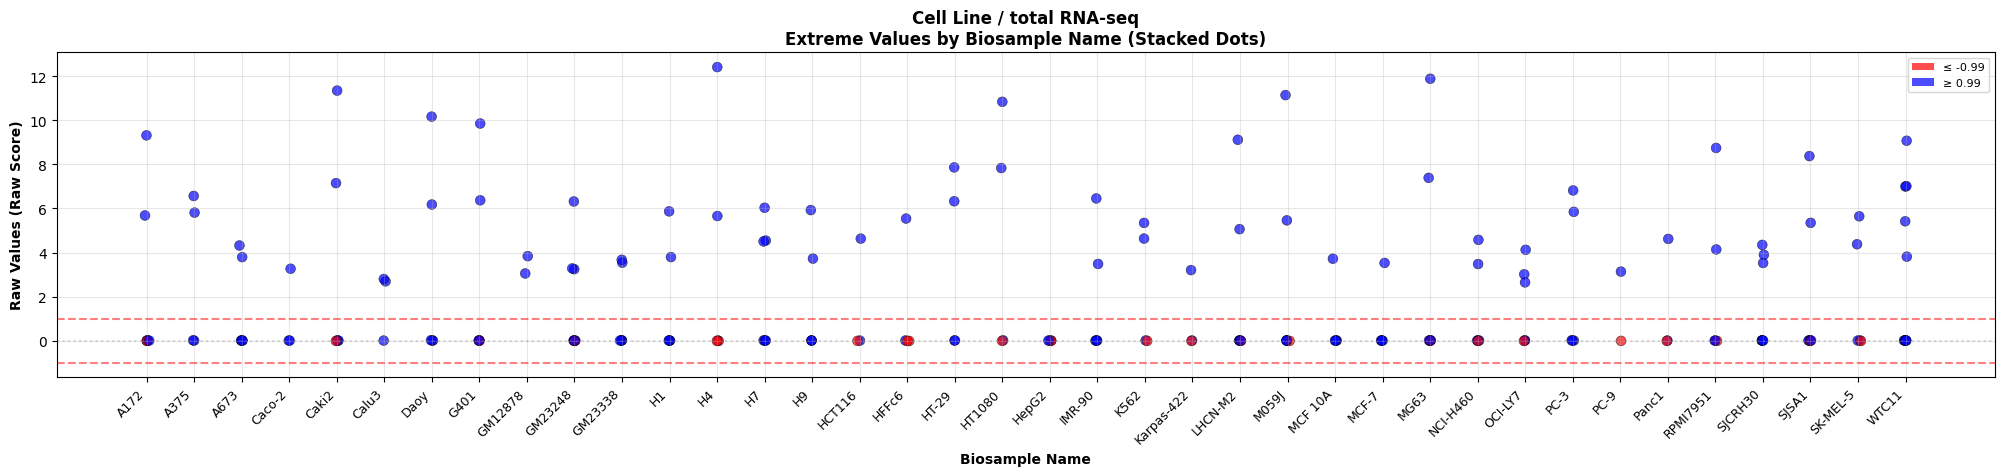

   Statistics:
     Mean: 2.0696
     Min: -0.0107
     Max: 12.4136
     Very low (≤-0.99): 0
     Very high (≥0.99): 73
   Biosample frequency:
     WTC11: 12 entries
     GM23248: 9 entries
     SJCRH30: 8 entries
     H7: 7 entries
     A172: 7 entries
     M059J: 7 entries
     SJSA1: 7 entries
     LHCN-M2: 7 entries
     MG63: 7 entries
     NCI-H460: 6 entries
     A673: 6 entries
     OCI-LY7: 6 entries
     GM23338: 6 entries
     Caki2: 6 entries
     H1: 6 entries
     IMR-90: 6 entries
     G401: 6 entries
     MCF 10A: 5 entries
     RPMI7951: 5 entries
     MCF-7: 5 entries
     H4: 5 entries
     Daoy: 5 entries
     SK-MEL-5: 5 entries
     H9: 5 entries
     PC-3: 5 entries
     A375: 4 entries
     HFFc6: 4 entries
     K562: 4 entries
     HepG2: 4 entries
     HT-29: 4 entries
     HT1080: 4 entries
     Caco-2: 3 entries
     Calu3: 3 entries
     HCT116: 3 entries
     Panc1: 3 entries
     Karpas-422: 3 entries
     GM12878: 2 entries
     PC-9: 2 entries

📈 Plo

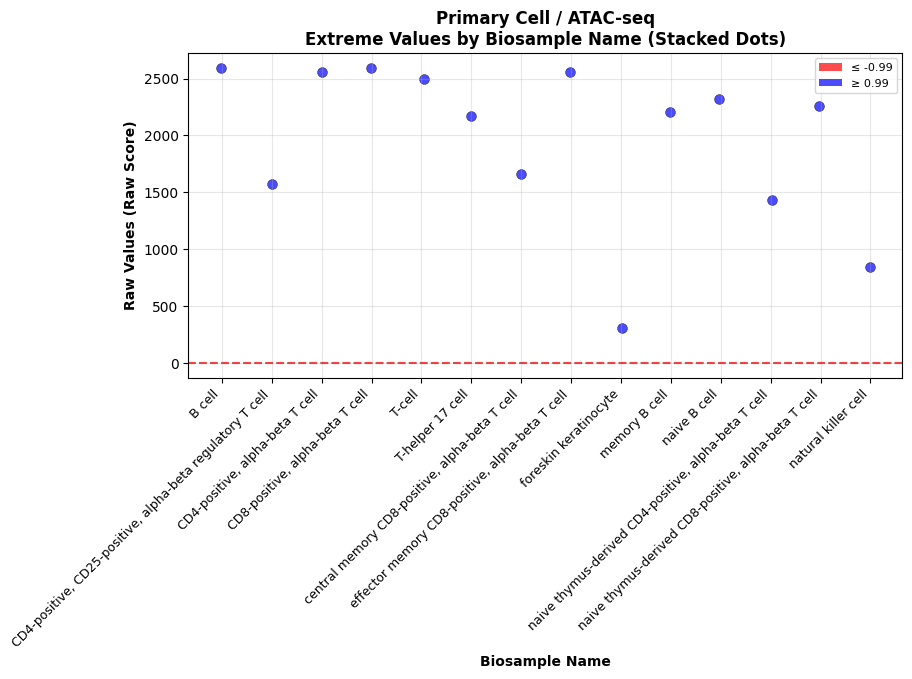

   Statistics:
     Mean: 1968.6187
     Min: 309.5140
     Max: 2595.7732
     Very low (≤-0.99): 0
     Very high (≥0.99): 14
   Biosample frequency:
     B cell: 1 entries
     CD4-positive, CD25-positive, alpha-beta regulatory T cell: 1 entries
     CD4-positive, alpha-beta T cell: 1 entries
     CD8-positive, alpha-beta T cell: 1 entries
     T-cell: 1 entries
     T-helper 17 cell: 1 entries
     central memory CD8-positive, alpha-beta T cell: 1 entries
     effector memory CD8-positive, alpha-beta T cell: 1 entries
     foreskin keratinocyte: 1 entries
     memory B cell: 1 entries
     naive B cell: 1 entries
     naive thymus-derived CD4-positive, alpha-beta T cell: 1 entries
     naive thymus-derived CD8-positive, alpha-beta T cell: 1 entries
     natural killer cell: 1 entries

📈 Plotting: primary_cell / DNase-seq
   Entries: 82
   Unique biosample names: 82


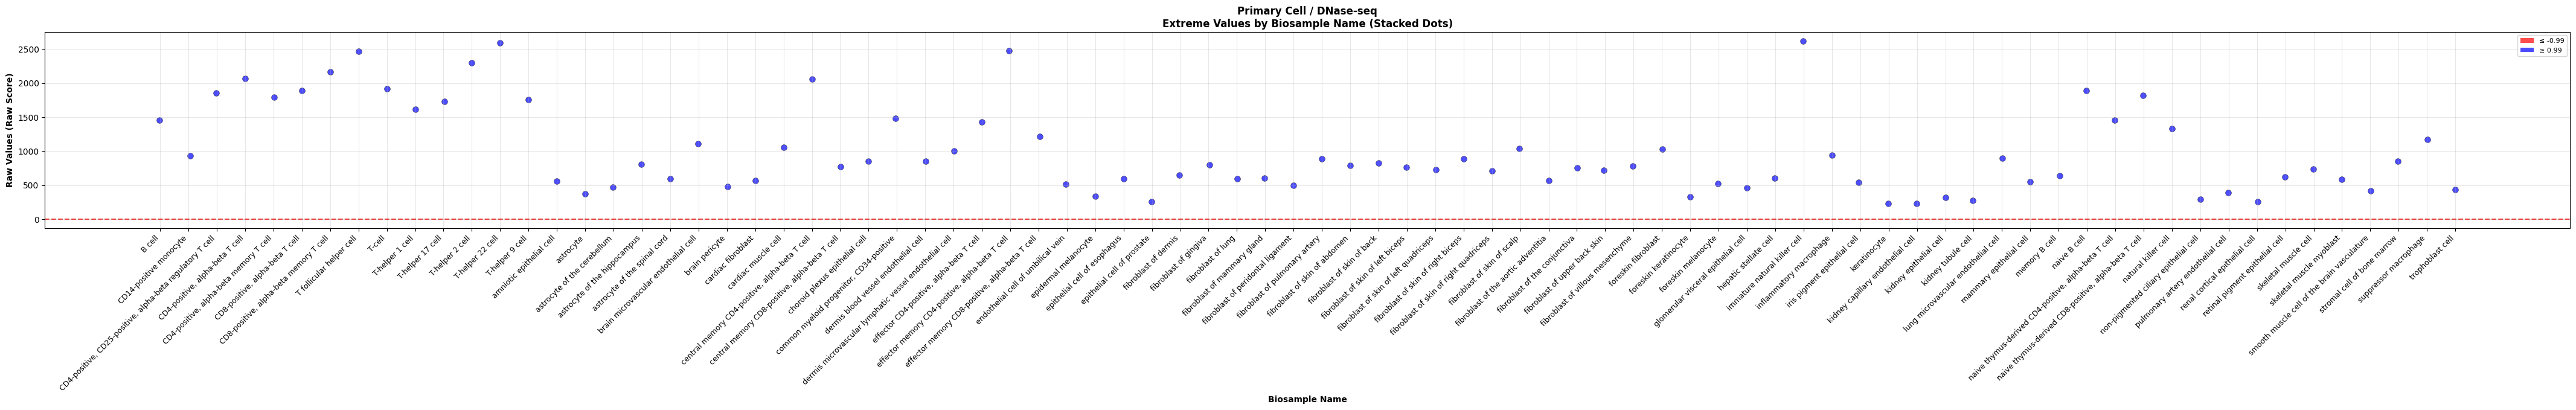

   Statistics:
     Mean: 992.7039
     Min: 230.7172
     Max: 2620.0063
     Very low (≤-0.99): 0
     Very high (≥0.99): 82
   Biosample frequency:
     B cell: 1 entries
     CD14-positive monocyte: 1 entries
     CD4-positive, CD25-positive, alpha-beta regulatory T cell: 1 entries
     CD4-positive, alpha-beta T cell: 1 entries
     CD4-positive, alpha-beta memory T cell: 1 entries
     CD8-positive, alpha-beta T cell: 1 entries
     CD8-positive, alpha-beta memory T cell: 1 entries
     T follicular helper cell: 1 entries
     T-cell: 1 entries
     T-helper 1 cell: 1 entries
     T-helper 17 cell: 1 entries
     T-helper 2 cell: 1 entries
     T-helper 22 cell: 1 entries
     T-helper 9 cell: 1 entries
     amniotic epithelial cell: 1 entries
     astrocyte: 1 entries
     astrocyte of the cerebellum: 1 entries
     astrocyte of the hippocampus: 1 entries
     astrocyte of the spinal cord: 1 entries
     brain microvascular endothelial cell: 1 entries
     brain pericyte: 1 entr

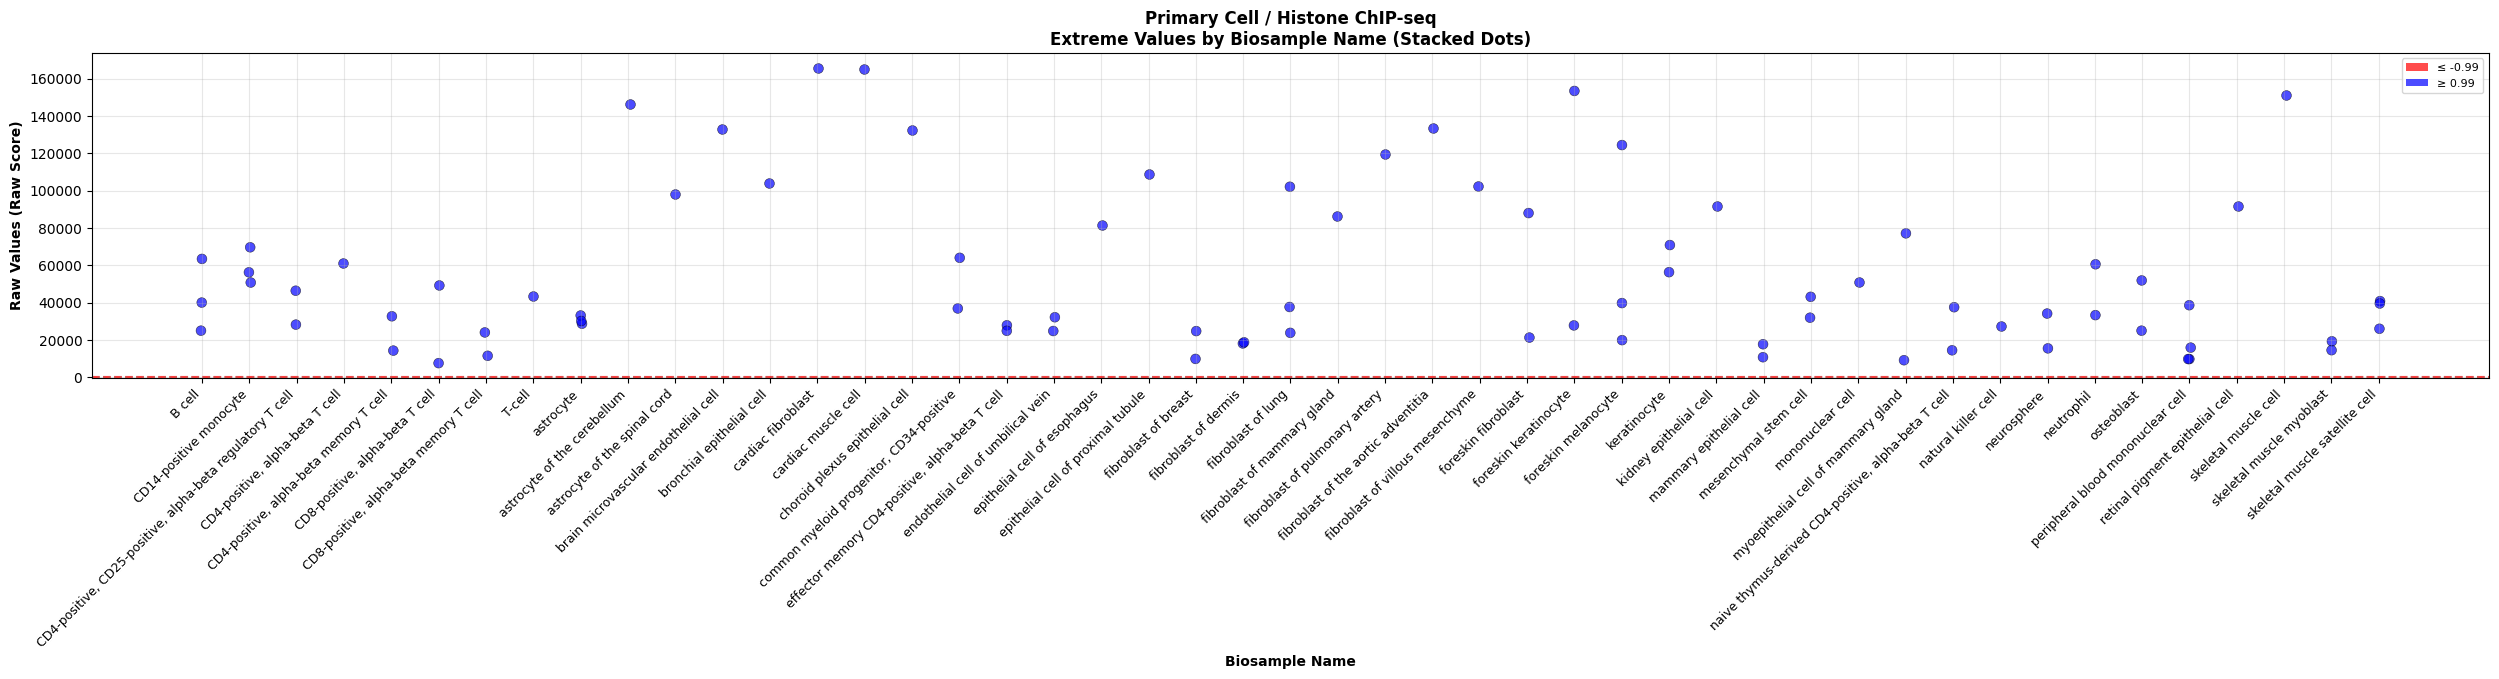

   Statistics:
     Mean: 54076.0716
     Min: 7644.2500
     Max: 165870.0000
     Very low (≤-0.99): 0
     Very high (≥0.99): 82
   Biosample frequency:
     peripheral blood mononuclear cell: 4 entries
     CD14-positive monocyte: 3 entries
     B cell: 3 entries
     fibroblast of lung: 3 entries
     skeletal muscle satellite cell: 3 entries
     foreskin melanocyte: 3 entries
     astrocyte: 3 entries
     effector memory CD4-positive, alpha-beta T cell: 2 entries
     common myeloid progenitor, CD34-positive: 2 entries
     foreskin fibroblast: 2 entries
     fibroblast of breast: 2 entries
     CD4-positive, alpha-beta memory T cell: 2 entries
     CD8-positive, alpha-beta T cell: 2 entries
     CD8-positive, alpha-beta memory T cell: 2 entries
     CD4-positive, CD25-positive, alpha-beta regulatory T cell: 2 entries
     osteoblast: 2 entries
     skeletal muscle myoblast: 2 entries
     neurosphere: 2 entries
     myoepithelial cell of mammary gland: 2 entries
     mammary e

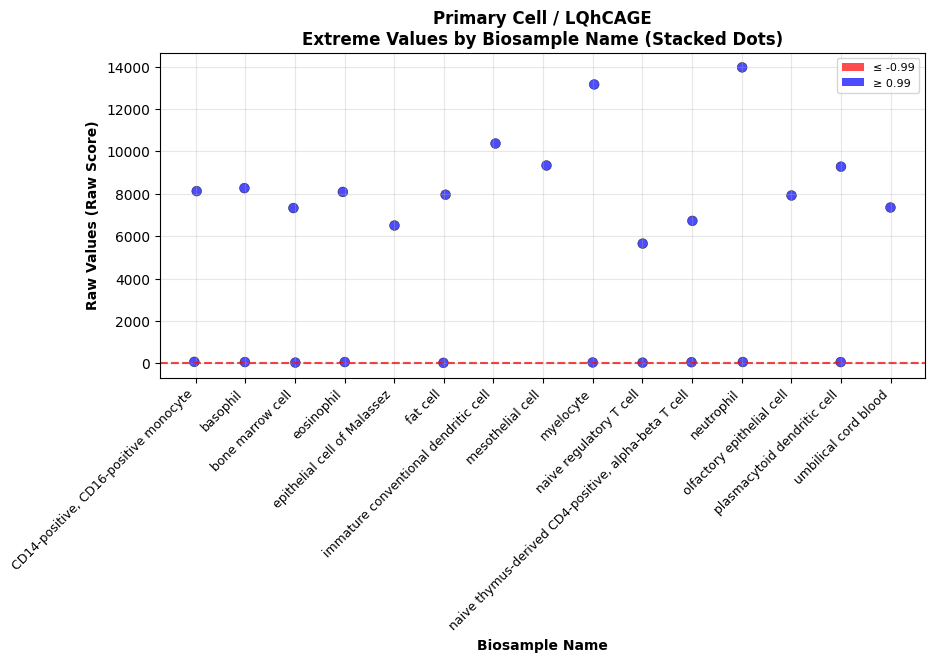

   Statistics:
     Mean: 5226.5451
     Min: 25.4511
     Max: 13960.2170
     Very low (≤-0.99): 0
     Very high (≥0.99): 25
   Biosample frequency:
     CD14-positive, CD16-positive monocyte: 2 entries
     basophil: 2 entries
     bone marrow cell: 2 entries
     eosinophil: 2 entries
     fat cell: 2 entries
     naive regulatory T cell: 2 entries
     myelocyte: 2 entries
     plasmacytoid dendritic cell: 2 entries
     neutrophil: 2 entries
     naive thymus-derived CD4-positive, alpha-beta T cell: 2 entries
     epithelial cell of Malassez: 1 entries
     immature conventional dendritic cell: 1 entries
     mesothelial cell: 1 entries
     olfactory epithelial cell: 1 entries
     umbilical cord blood: 1 entries

📈 Plotting: primary_cell / PRO-cap
   Entries: 2
   Unique biosample names: 1


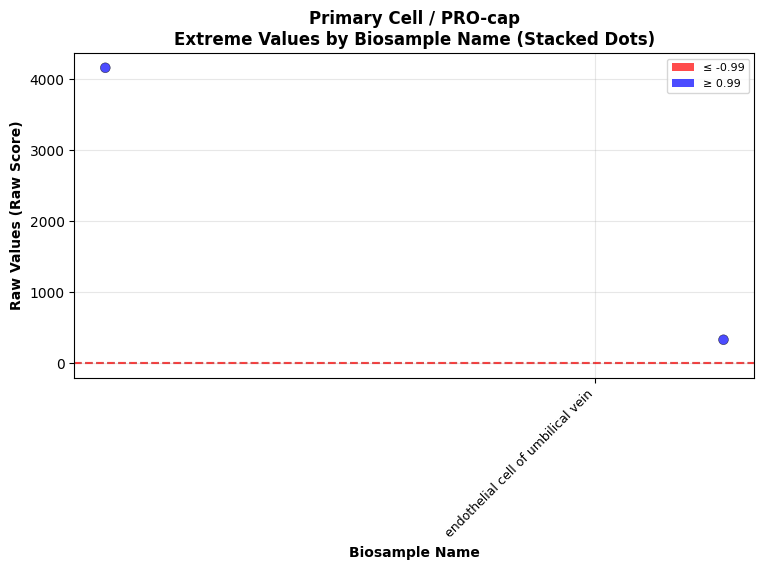

   Statistics:
     Mean: 2244.8647
     Min: 329.7661
     Max: 4159.9634
     Very low (≤-0.99): 0
     Very high (≥0.99): 2
   Biosample frequency:
     endothelial cell of umbilical vein: 2 entries

📈 Plotting: primary_cell / TF ChIP-seq
   Entries: 6
   Unique biosample names: 3


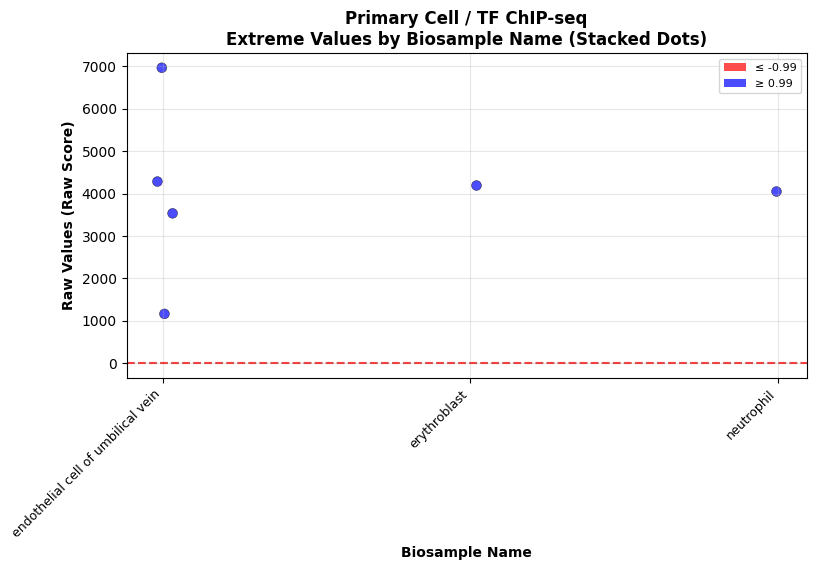

   Statistics:
     Mean: 4032.8333
     Min: 1163.0000
     Max: 6968.0000
     Very low (≤-0.99): 0
     Very high (≥0.99): 6
   Biosample frequency:
     endothelial cell of umbilical vein: 4 entries
     erythroblast: 1 entries
     neutrophil: 1 entries

📈 Plotting: primary_cell / hCAGE
   Entries: 152
   Unique biosample names: 137


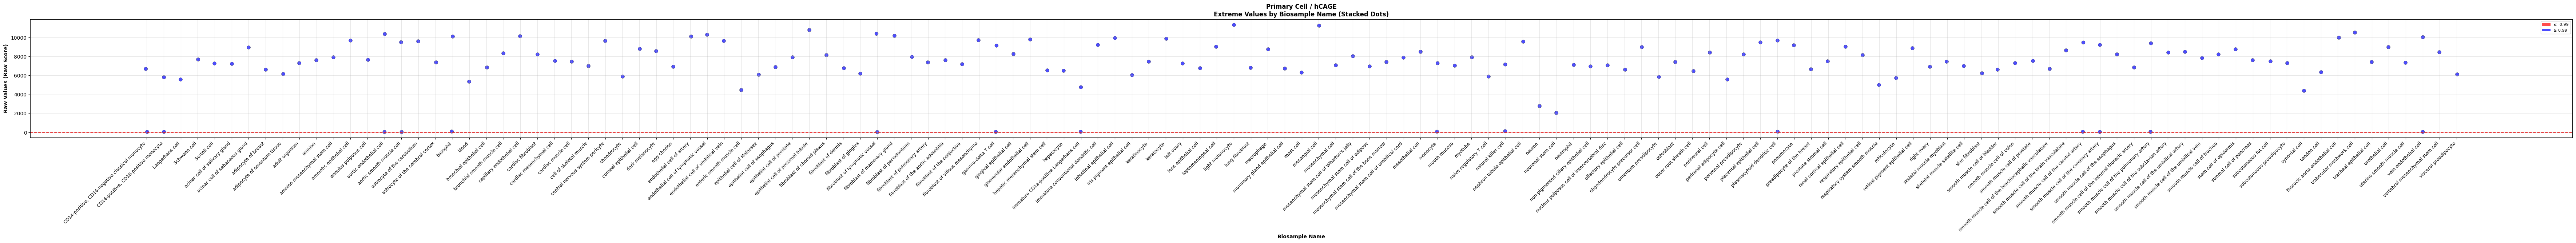

   Statistics:
     Mean: 7021.1423
     Min: 28.3701
     Max: 11367.6960
     Very low (≤-0.99): 0
     Very high (≥0.99): 152
   Biosample frequency:
     CD14-positive, CD16-negative classical monocyte: 2 entries
     CD14-positive, CD16-positive monocyte: 2 entries
     natural killer cell: 2 entries
     immature CD1a-positive Langerhans cell: 2 entries
     gamma-delta T cell: 2 entries
     fibroblast of lymphatic vessel: 2 entries
     basophil: 2 entries
     aortic endothelial cell: 2 entries
     aortic smooth muscle cell: 2 entries
     smooth muscle cell of the coronary artery: 2 entries
     smooth muscle cell of the pulmonary artery: 2 entries
     smooth muscle cell of the carotid artery: 2 entries
     vein endothelial cell: 2 entries
     plasmacytoid dendritic cell: 2 entries
     monocyte: 2 entries
     Langerhans cell: 1 entries
     Schwann cell: 1 entries
     adipocyte of omentum tissue: 1 entries
     adipocyte of breast: 1 entries
     acinar cell of sebaceo

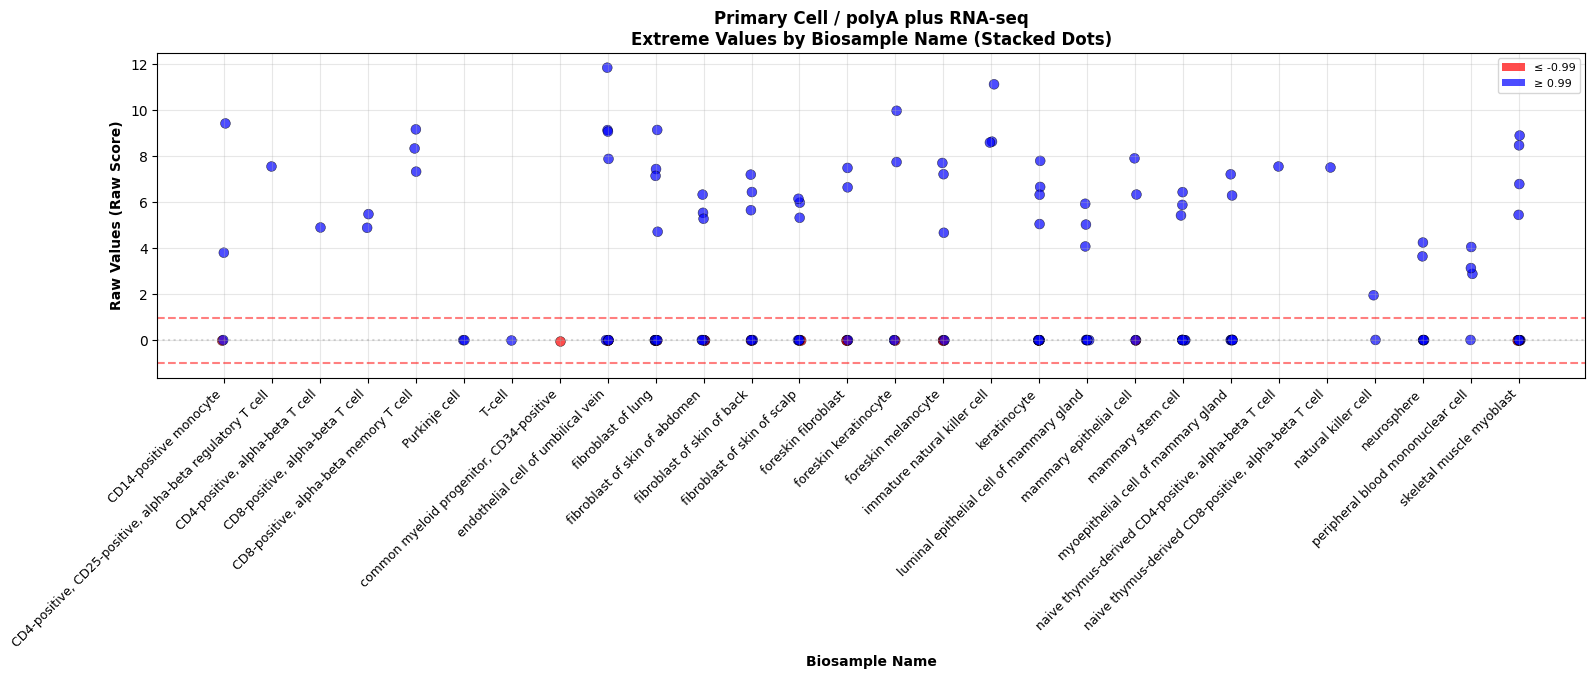

   Statistics:
     Mean: 2.5790
     Min: -0.0137
     Max: 11.8488
     Very low (≤-0.99): 0
     Very high (≥0.99): 62
   Biosample frequency:
     fibroblast of lung: 17 entries
     keratinocyte: 12 entries
     skeletal muscle myoblast: 12 entries
     endothelial cell of umbilical vein: 10 entries
     mammary stem cell: 10 entries
     fibroblast of skin of scalp: 9 entries
     fibroblast of skin of abdomen: 9 entries
     fibroblast of skin of back: 9 entries
     myoepithelial cell of mammary gland: 8 entries
     luminal epithelial cell of mammary gland: 8 entries
     foreskin fibroblast: 7 entries
     foreskin melanocyte: 7 entries
     neurosphere: 6 entries
     foreskin keratinocyte: 5 entries
     mammary epithelial cell: 5 entries
     peripheral blood mononuclear cell: 4 entries
     CD14-positive monocyte: 4 entries
     immature natural killer cell: 3 entries
     CD8-positive, alpha-beta memory T cell: 3 entries
     CD8-positive, alpha-beta T cell: 2 entries
  

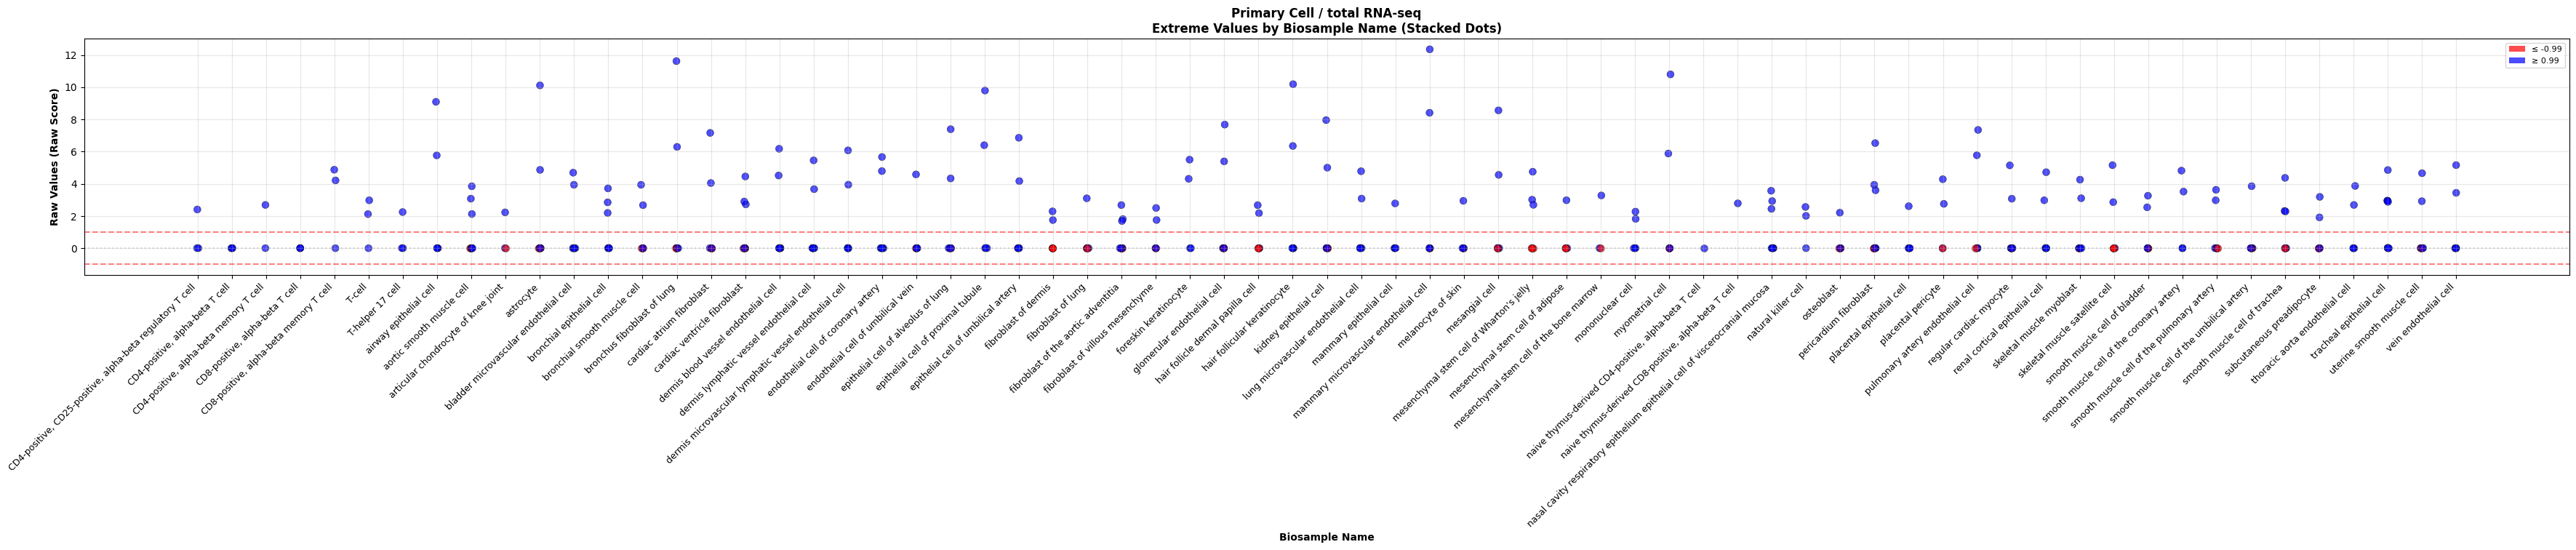

   Statistics:
     Mean: 1.3877
     Min: -0.0112
     Max: 12.3497
     Very low (≤-0.99): 0
     Very high (≥0.99): 124
   Biosample frequency:
     fibroblast of the aortic adventitia: 9 entries
     cardiac ventricle fibroblast: 9 entries
     aortic smooth muscle cell: 9 entries
     pericardium fibroblast: 9 entries
     regular cardiac myocyte: 8 entries
     nasal cavity respiratory epithelium epithelial cell of viscerocranial mucosa: 8 entries
     tracheal epithelial cell: 8 entries
     dermis lymphatic vessel endothelial cell: 8 entries
     dermis blood vessel endothelial cell: 8 entries
     astrocyte: 8 entries
     bronchus fibroblast of lung: 8 entries
     mesenchymal stem cell of Wharton's jelly: 7 entries
     mesangial cell: 7 entries
     smooth muscle cell of bladder: 7 entries
     glomerular endothelial cell: 7 entries
     endothelial cell of coronary artery: 7 entries
     epithelial cell of alveolus of lung: 7 entries
     kidney epithelial cell: 7 entries


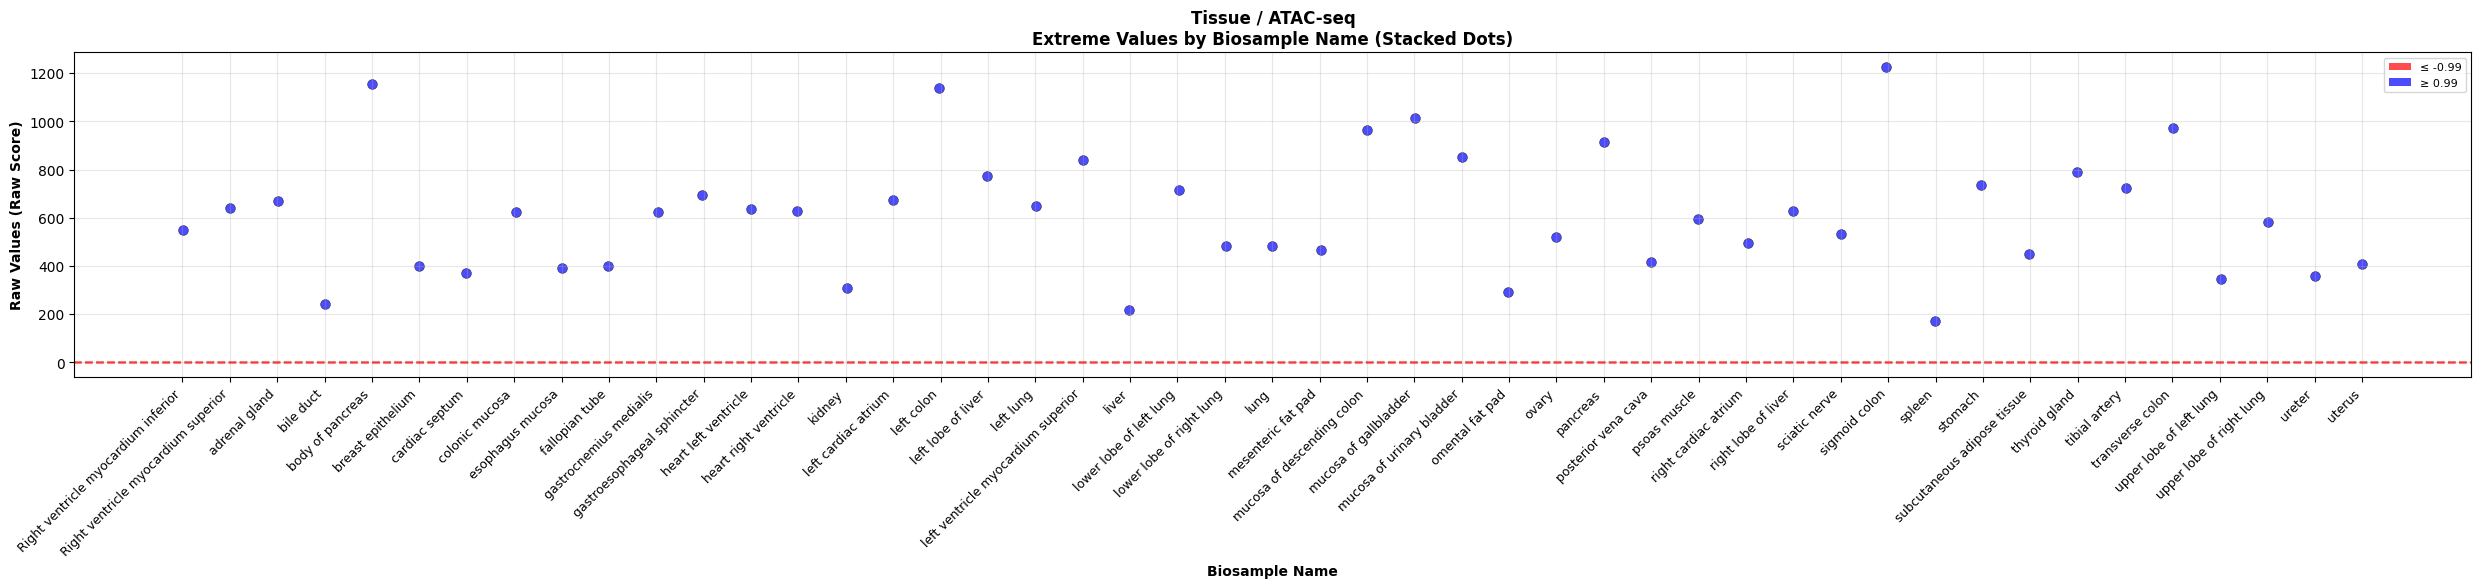

   Statistics:
     Mean: 611.7110
     Min: 172.5196
     Max: 1224.8962
     Very low (≤-0.99): 0
     Very high (≥0.99): 47
   Biosample frequency:
     Right ventricle myocardium inferior: 1 entries
     Right ventricle myocardium superior: 1 entries
     adrenal gland: 1 entries
     bile duct: 1 entries
     body of pancreas: 1 entries
     breast epithelium: 1 entries
     cardiac septum: 1 entries
     colonic mucosa: 1 entries
     esophagus mucosa: 1 entries
     fallopian tube: 1 entries
     gastrocnemius medialis: 1 entries
     gastroesophageal sphincter: 1 entries
     heart left ventricle: 1 entries
     heart right ventricle: 1 entries
     kidney: 1 entries
     left cardiac atrium: 1 entries
     left colon: 1 entries
     left lobe of liver: 1 entries
     left lung: 1 entries
     left ventricle myocardium superior: 1 entries
     liver: 1 entries
     lower lobe of left lung: 1 entries
     lower lobe of right lung: 1 entries
     lung: 1 entries
     mesenteric f

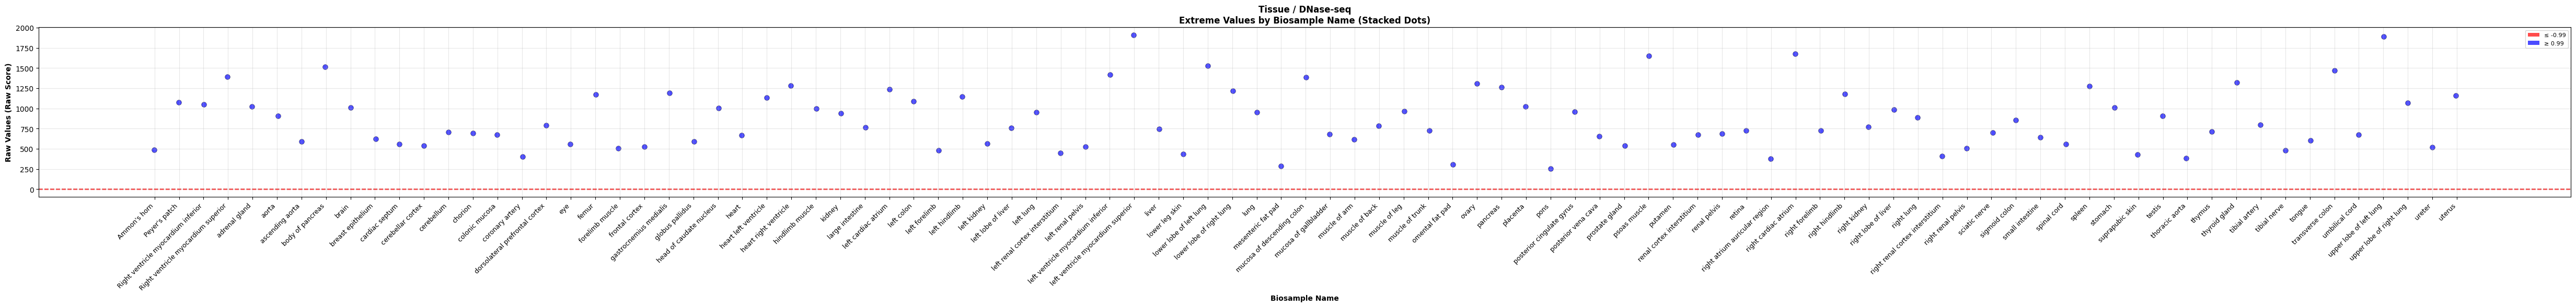

   Statistics:
     Mean: 861.1579
     Min: 256.9780
     Max: 1907.9973
     Very low (≤-0.99): 0
     Very high (≥0.99): 95
   Biosample frequency:
     Ammon's horn: 1 entries
     Peyer's patch: 1 entries
     Right ventricle myocardium inferior: 1 entries
     Right ventricle myocardium superior: 1 entries
     adrenal gland: 1 entries
     aorta: 1 entries
     ascending aorta: 1 entries
     body of pancreas: 1 entries
     brain: 1 entries
     breast epithelium: 1 entries
     cardiac septum: 1 entries
     cerebellar cortex: 1 entries
     cerebellum: 1 entries
     chorion: 1 entries
     colonic mucosa: 1 entries
     coronary artery: 1 entries
     dorsolateral prefrontal cortex: 1 entries
     eye: 1 entries
     femur: 1 entries
     forelimb muscle: 1 entries
     frontal cortex: 1 entries
     gastrocnemius medialis: 1 entries
     globus pallidus: 1 entries
     head of caudate nucleus: 1 entries
     heart: 1 entries
     heart left ventricle: 1 entries
     heart r

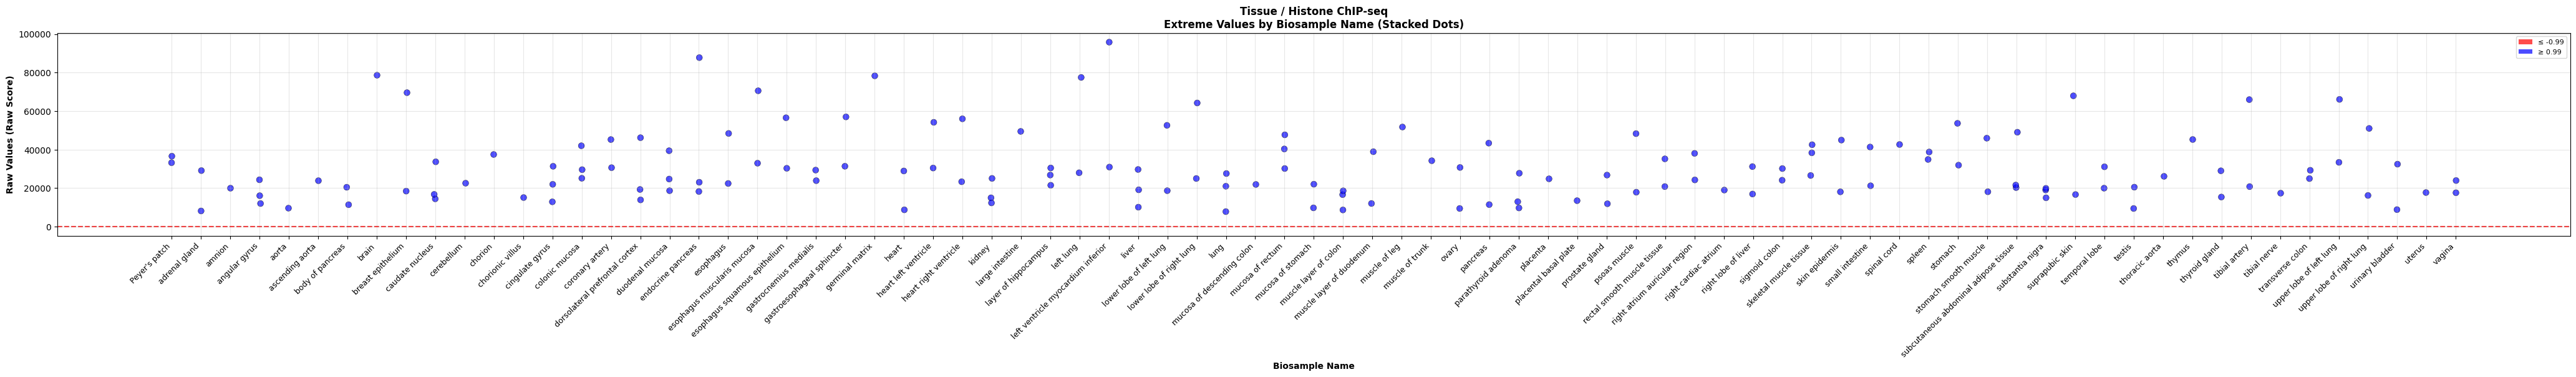

   Statistics:
     Mean: 30223.5444
     Min: 7773.7500
     Max: 95805.0000
     Very low (≤-0.99): 0
     Very high (≥0.99): 155
   Biosample frequency:
     angular gyrus: 3 entries
     colonic mucosa: 3 entries
     caudate nucleus: 3 entries
     cingulate gyrus: 3 entries
     subcutaneous abdominal adipose tissue: 3 entries
     parathyroid adenoma: 3 entries
     muscle layer of colon: 3 entries
     liver: 3 entries
     lung: 3 entries
     mucosa of rectum: 3 entries
     kidney: 3 entries
     layer of hippocampus: 3 entries
     endocrine pancreas: 3 entries
     duodenal mucosa: 3 entries
     dorsolateral prefrontal cortex: 3 entries
     substantia nigra: 3 entries
     skeletal muscle tissue: 3 entries
     upper lobe of left lung: 2 entries
     urinary bladder: 2 entries
     vagina: 2 entries
     skin epidermis: 2 entries
     right atrium auricular region: 2 entries
     breast epithelium: 2 entries
     Peyer's patch: 2 entries
     adrenal gland: 2 entries
   

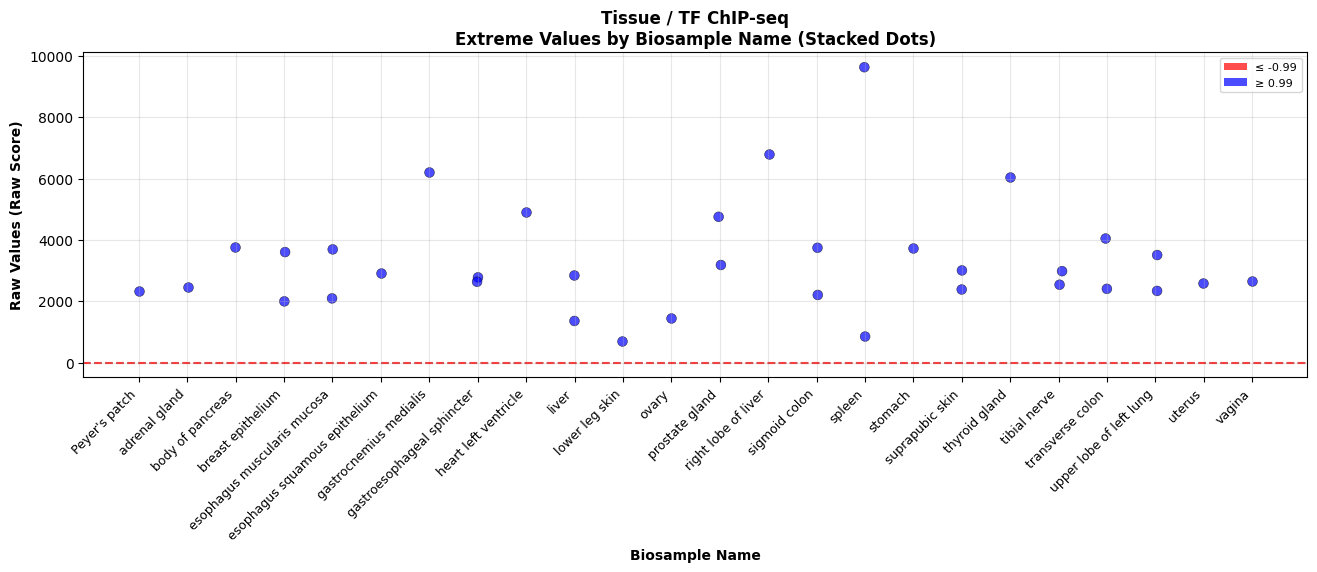

   Statistics:
     Mean: 3289.9857
     Min: 696.0000
     Max: 9632.0000
     Very low (≤-0.99): 0
     Very high (≥0.99): 35
   Biosample frequency:
     breast epithelium: 2 entries
     esophagus muscularis mucosa: 2 entries
     gastroesophageal sphincter: 2 entries
     transverse colon: 2 entries
     prostate gland: 2 entries
     sigmoid colon: 2 entries
     spleen: 2 entries
     liver: 2 entries
     tibial nerve: 2 entries
     upper lobe of left lung: 2 entries
     suprapubic skin: 2 entries
     gastrocnemius medialis: 1 entries
     Peyer's patch: 1 entries
     esophagus squamous epithelium: 1 entries
     adrenal gland: 1 entries
     body of pancreas: 1 entries
     right lobe of liver: 1 entries
     heart left ventricle: 1 entries
     lower leg skin: 1 entries
     ovary: 1 entries
     thyroid gland: 1 entries
     stomach: 1 entries
     uterus: 1 entries
     vagina: 1 entries

📈 Plotting: tissue / hCAGE
   Entries: 105
   Unique biosample names: 102


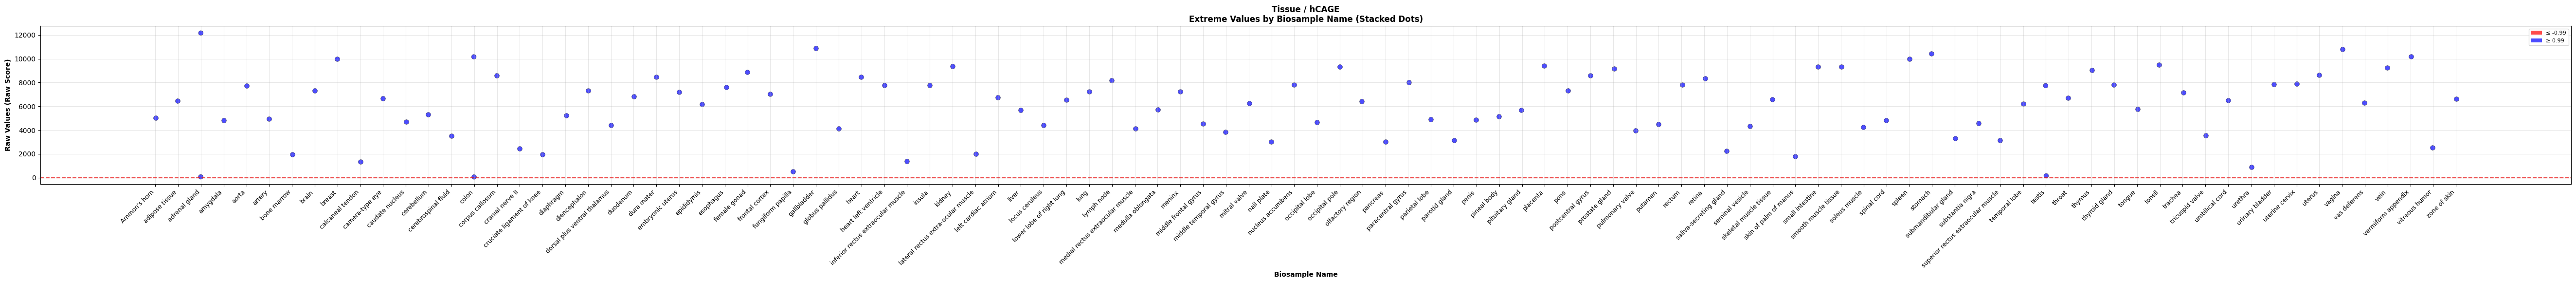

   Statistics:
     Mean: 6068.7373
     Min: 54.5549
     Max: 12159.6280
     Very low (≤-0.99): 0
     Very high (≥0.99): 105
   Biosample frequency:
     adrenal gland: 2 entries
     colon: 2 entries
     testis: 2 entries
     adipose tissue: 1 entries
     aorta: 1 entries
     amygdala: 1 entries
     artery: 1 entries
     bone marrow: 1 entries
     breast: 1 entries
     brain: 1 entries
     camera-type eye: 1 entries
     caudate nucleus: 1 entries
     cerebellum: 1 entries
     calcaneal tendon: 1 entries
     cerebrospinal fluid: 1 entries
     corpus callosum: 1 entries
     cranial nerve II: 1 entries
     cruciate ligament of knee: 1 entries
     diaphragm: 1 entries
     diencephalon: 1 entries
     dorsal plus ventral thalamus: 1 entries
     duodenum: 1 entries
     dura mater: 1 entries
     embryonic uterus: 1 entries
     epididymis: 1 entries
     esophagus: 1 entries
     female gonad: 1 entries
     frontal cortex: 1 entries
     fungiform papilla: 1 entries

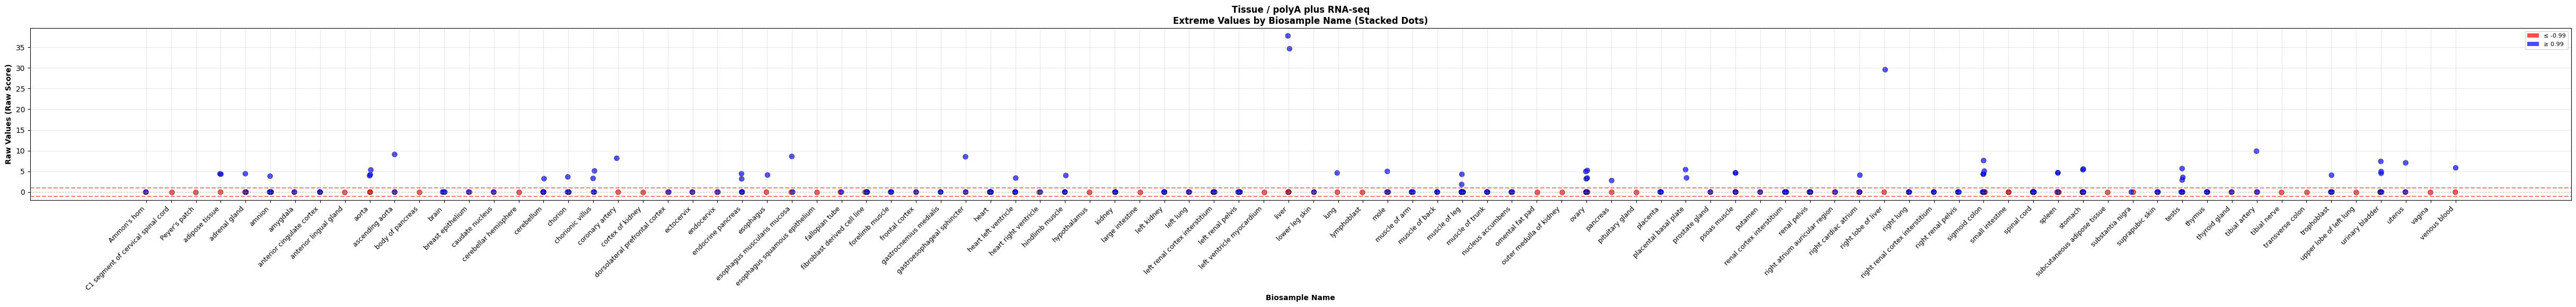

   Statistics:
     Mean: 1.1386
     Min: -0.0484
     Max: 37.7447
     Very low (≤-0.99): 0
     Very high (≥0.99): 55
   Biosample frequency:
     muscle of leg: 14 entries
     ovary: 11 entries
     sigmoid colon: 11 entries
     spinal cord: 10 entries
     urinary bladder: 8 entries
     stomach: 8 entries
     testis: 7 entries
     heart: 7 entries
     endocrine pancreas: 6 entries
     cerebellum: 6 entries
     fibroblast derived cell line: 6 entries
     psoas muscle: 6 entries
     spleen: 6 entries
     amnion: 5 entries
     heart left ventricle: 5 entries
     kidney: 5 entries
     muscle of trunk: 5 entries
     left renal pelvis: 5 entries
     aorta: 5 entries
     liver: 5 entries
     left kidney: 4 entries
     adrenal gland: 4 entries
     chorion: 4 entries
     chorionic villus: 4 entries
     renal pelvis: 4 entries
     trophoblast: 4 entries
     renal cortex interstitium: 4 entries
     hindlimb muscle: 4 entries
     left renal cortex interstitium: 4 en

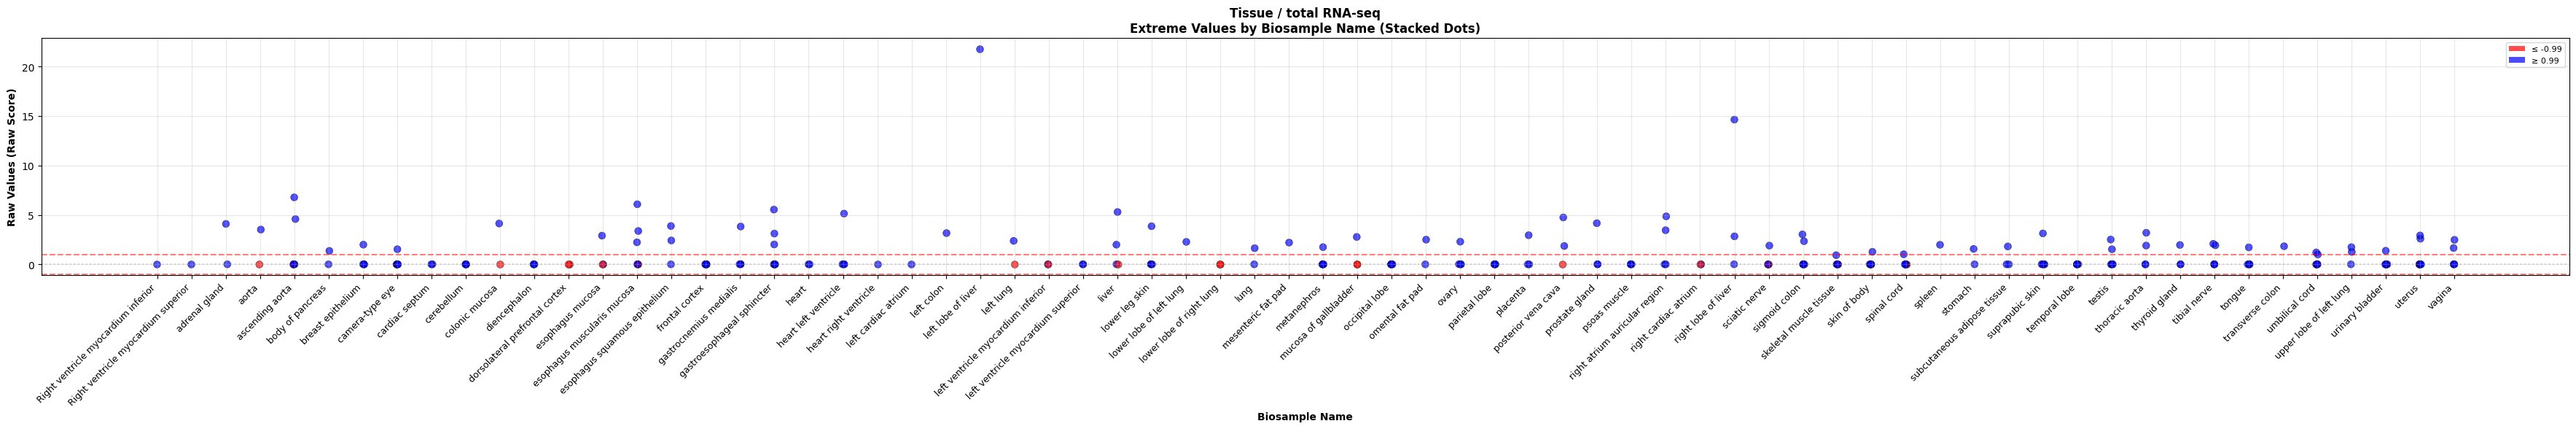

   Statistics:
     Mean: 0.9223
     Min: -0.0100
     Max: 21.7923
     Very low (≤-0.99): 0
     Very high (≥0.99): 67
   Biosample frequency:
     uterus: 8 entries
     gastroesophageal sphincter: 8 entries
     umbilical cord: 7 entries
     ascending aorta: 6 entries
     sigmoid colon: 6 entries
     skin of body: 6 entries
     testis: 6 entries
     urinary bladder: 6 entries
     frontal cortex: 6 entries
     spinal cord: 6 entries
     esophagus muscularis mucosa: 6 entries
     camera-type eye: 6 entries
     tibial nerve: 5 entries
     suprapubic skin: 5 entries
     skeletal muscle tissue: 5 entries
     vagina: 5 entries
     occipital lobe: 5 entries
     metanephros: 5 entries
     tongue: 5 entries
     ovary: 4 entries
     lower leg skin: 4 entries
     liver: 4 entries
     heart left ventricle: 4 entries
     cerebellum: 4 entries
     sciatic nerve: 4 entries
     parietal lobe: 4 entries
     breast epithelium: 4 entries
     gastrocnemius medialis: 4 entries

In [15]:
# Plot biosample_name vs raw values for extreme quantile scores
print("🔬 EXTREME VALUES: BIOSAMPLE NAME vs RAW VALUES BY CELL TYPE AND ASSAY")

# Step 1: Restrict to rows with quantile score ≤-0.99 or ≥0.99
target_types = ['tissue', 'cell_line', 'primary_cell']  # Order as requested
df_filtered = df[df['biosample_type'].isin(target_types)].copy()

# Filter for extreme quantile scores
extreme_mask = (df_filtered['quantile_score'] <= -0.99) | (df_filtered['quantile_score'] >= 0.99)
df_extreme = df_filtered[extreme_mask].copy()

print(f"Original data: {len(df):,} entries")
print(f"Filtered for target cell types: {len(df_filtered):,} entries")
print(f"Extreme values (≤-0.99 or ≥0.99): {len(df_extreme):,} entries")

if len(df_extreme) == 0:
    print("❌ No extreme values found with threshold ±0.99")
    # Fallback to ±0.95
    extreme_mask = (df_filtered['quantile_score'] <= -0.95) | (df_filtered['quantile_score'] >= 0.95)
    df_extreme = df_filtered[extreme_mask].copy()
    print(f"Using threshold ±0.95: {len(df_extreme)} entries")

if len(df_extreme) > 0:
    # Check required columns
    required_cols = ['biosample_type', 'Assay title', 'biosample_name', 'quantile_score']
    missing_cols = [col for col in required_cols if col not in df_extreme.columns]
    if missing_cols:
        print(f"⚠️ Missing required columns: {missing_cols}")
        print(f"Available columns: {list(df_extreme.columns)}")
    
    # Remove rows with NaN in required columns
    df_extreme = df_extreme.dropna(subset=[col for col in required_cols if col in df_extreme.columns])
    print(f"After removing NaN values: {len(df_extreme):,} entries")
    
    # Step 2 & 3: Sort by biosample_type, then by assay title
    df_extreme = df_extreme.sort_values(['biosample_type', 'Assay title', 'biosample_name'])
    
    # Get unique combinations of biosample_type and assay
    combinations = df_extreme.groupby(['biosample_type', 'Assay title']).size().reset_index(name='count')
    combinations = combinations.sort_values(['biosample_type', 'Assay title'])
    
    print(f"\n📊 Found {len(combinations)} combinations of cell type + assay:")
    for _, row in combinations.iterrows():
        print(f"  {row['biosample_type']} / {row['Assay title']}: {row['count']} entries")
    
    # Step 4: Plot each combination
    for _, combo in combinations.iterrows():
        cell_type = combo['biosample_type']
        assay = combo['Assay title']
        
        # Get data for this specific combination
        combo_data = df_extreme[(df_extreme['biosample_type'] == cell_type) & 
                               (df_extreme['Assay title'] == assay)].copy()
        
        if len(combo_data) == 0:
            continue
            
        print(f"\n📈 Plotting: {cell_type} / {assay}")
        print(f"   Entries: {len(combo_data)}")
        print(f"   Unique biosample names: {combo_data['biosample_name'].nunique()}")
        
        # Group data by biosample_name to enable stacking
        unique_biosamples = combo_data['biosample_name'].unique()
        
        # Create the plot with more compressed sizing
        plt.figure(figsize=(max(8, len(unique_biosamples) * 0.6), 5))
        
        # Plot stacked dots for each unique biosample name
        for i, biosample in enumerate(unique_biosamples):
            # Get all data points for this biosample
            biosample_data = combo_data[combo_data['biosample_name'] == biosample]
            raw_values = biosample_data['raw_score'].values
            quantile_scores = biosample_data['quantile_score'].values
            
            # Create x positions (same x for all dots of this biosample)
            x_positions = [i] * len(raw_values)
            
            # Add small horizontal jitter to avoid complete overlap
            jitter = np.random.normal(0, 0.02, len(raw_values))
            x_jittered = [x + j for x, j in zip(x_positions, jitter)]
            
            # Create colors based on quantile_score ranges
            colors = ['red' if val <= -0.99 else 'blue' for val in quantile_scores]
            
            # Plot the dots for this biosample
            plt.scatter(x_jittered, raw_values, c=colors, alpha=0.7, s=50, 
                       edgecolors='black', linewidth=0.4)
        
        # Customize plot with compressed spacing
        plt.xticks(range(len(unique_biosamples)), unique_biosamples, 
                  rotation=45, ha='right', fontsize=9)
        plt.ylabel('Raw Values (Raw Score)', fontsize=10, fontweight='bold')
        plt.xlabel('Biosample Name', fontsize=10, fontweight='bold')
        plt.title(f'{cell_type.replace("_", " ").title()} / {assay}\nExtreme Values by Biosample Name (Stacked Dots)', 
                 fontsize=12, fontweight='bold')
        
        # Add reference lines
        plt.axhline(y=-0.99, color='red', linestyle='--', alpha=0.5, label='±0.99 threshold')
        plt.axhline(y=0.99, color='red', linestyle='--', alpha=0.5)
        plt.axhline(y=0, color='gray', linestyle=':', alpha=0.3)
        
        # Add legend with smaller font
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='red', alpha=0.7, label='≤ -0.99'),
                          Patch(facecolor='blue', alpha=0.7, label='≥ 0.99')]
        plt.legend(handles=legend_elements, loc='upper right', fontsize=8)
        
        plt.grid(alpha=0.3)
        # Adjust layout parameters for compression
        plt.subplots_adjust(bottom=0.2, left=0.1, right=0.95, top=0.85)
        plt.show()
        
        # Print statistics for this combination
        raw_values_all = combo_data['raw_score']
        print(f"   Statistics:")
        print(f"     Mean: {raw_values_all.mean():.4f}")
        print(f"     Min: {raw_values_all.min():.4f}")
        print(f"     Max: {raw_values_all.max():.4f}")
        print(f"     Very low (≤-0.99): {(raw_values_all <= -0.99).sum()}")
        print(f"     Very high (≥0.99): {(raw_values_all >= 0.99).sum()}")
        
        # Print biosample-specific counts
        print(f"   Biosample frequency:")
        biosample_counts = combo_data['biosample_name'].value_counts()
        for biosample, count in biosample_counts.items():
            print(f"     {biosample}: {count} entries")

else:
    print("❌ No extreme values found even with relaxed thresholds.")